# <center>Ejercicio 2 - Modelos de Clasificación Binaria</center>
# <center>Grupo 11</center>

#Integrantes:
- Blas Chuc - 110253
- Franco Rodriguez - 108799
- Helen Chen - 110195
- Tomas Caporaletti - 108598
- Lorenzo Busato - 110490

### Librerias necesarias

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.impute import KNNImputer

# Para modelos en general:
from sklearn.model_selection import StratifiedKFold, KFold, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import f1_score, make_scorer, roc_curve, auc, classification_report
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
import pickle

# Para arboles:
from sklearn import tree
from sklearn.tree import plot_tree, export_text
from sklearn.tree import DecisionTreeClassifier

# Random Forest:
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import RandomOverSampler

# XGBoost:
import xgboost as xgb

In [ ]:
!pip install -q gdown

### Carga del dataset de trabajo

In [ ]:
!gdown --id 1zkAJvdUJNNXa9ewF-0Taa6wfVtPQa13Y

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1zkAJvdUJNNXa9ewF-0Taa6wfVtPQa13Y
To: /content/weatherAUS.csv
100% 14.1M/14.1M [00:00<00:00, 51.5MB/s]


In [ ]:
ds_original = pd.read_csv('weatherAUS.csv')

# Dataset de trabajo:
ds = ds_original.copy()

### Análisis Exploratorio

**Descripción de los campos del dataset:**
- `Date`: Fecha de la observación (YYYY-MM-DD).
- `Location`: Nombre de la región para la estación meteorológica (e.g. Sydney, Melbourne, etc).
- `MinTemp`: La temperatura mínima medida en grados Celsius (°C).
- `MaxTemp`: La temperatura máxima medida en grados Celsius (°C).
- `Rainfall`: Cantidad de precipitación registrada en el día, medida en milímetros (mm).
- `Evaporation`: Evaporación medida con el método 'Class A pan', expresada en milímetros (mm), correspondiente a las 24 horas previas a las 9 am.
- `Sunshine`: Número de horas de sol brillante registradas durante el día.
- `WindGustDir`: Dirección de la ráfaga de viento más fuerte registrada en las 24 horas previas a la medianoche (e.g. N para norte, NE para noroeste, etc).
- `WindGustSpeed`: Velocidad (km/h) de la ráfaga de viento más fuerte registrada en las 24 horas previas a la medianoche.
- `WindDir9am`: Dirección del viento registrada a las 9 a.m. (e.g. N para norte, NE para noroeste, etc).
- `WindDir3pm`
- `WindSpeed9am`: Velocidad (km/h) del viento registrada a las 9 a.m., calculada como promedio durante los 10 minutos previos a esa hora.
- `WindSpeed3pm`
- `Humidity9am`: Humedad registrada a las 9 a.m., expresada como porcentaje (%).
- `Humidity3pm`
- `Pressure9am`: Presión atmosférica (hPa) registrada a las 9 a.m., ajustada al nivel medio del mar.
- `Pressure3pm`
- `Cloud9am`: Fracción del cielo cubierta por nubes a las 9 a.m., medida en oktas (unidad que divide el cielo en ocho partes). Cada valor indica cuántos octavos del cielo están cubiertos por nubes.
- `Cloud3pm`
- `Temp9am`: Temperatura registrada a las 9 a.m., medida en grados Celsius (°C).
- `Temp3pm`
- `RainToday`: **1** si la precipitación registrada en las 24 horas previas a las 9 a.m. supera 1mm, **0** en caso contrario.
- `RainTomorrow`: indicador que señala si se espera precipitación superior a 1mm en el día siguiente. Se utiliza como predicción de lluvia.

In [ ]:
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

Mostramos algunos de los registros

In [ ]:
ds.head(5)

Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0  2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1  2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2  2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3  2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4  2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   

  WindGustDir  WindGustSpeed WindDir9am  ... Humidity9am  Humidity3pm  \
0           W           44.0          W  ...        71.0         22.0   
1         WNW           44.0        NNW  ...        44.0         25.0   
2         WSW           46.0          W  ...        38.0         30.0   
3          NE           24.0         SE  ...        45.0         16.0   
4           W           41.0        ENE  ...        82.0         33.0   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
0       1007.7       1007.1       8.0       NaN     16.9     21.8         No   
1       1010.6       1007.8       NaN       NaN     17.2     24.3         No   
2       1007.6       1008.7       NaN       2.0     21.0     23.2         No   
3       1017.6       1012.8       NaN       NaN     18.1     26.5         No   
4       1010.8       1006.0       7.0       8.0     17.8     29.7         No   

   RainTomorrow  
0            No  
1            No  
2            No  
3            No  
4            No  

[5 rows x 23 columns]

In [ ]:
filas_totales = ds.shape[0]

#### Eliminación de registros de regiones que no son de interés.

Trabajaremos sobre las regiones de Queensland, Nueva Gales del Sur y Territorio de la Capital.

A continuación detallamos cuáles locations pertenecen a cada una de estas regiones.

> Locations en `Territorio de la Capital`:
> - Canberra
> - MountGinini
> - Tuggeranong

> Locations en `Queensland`:
> - Albany
> - Brisbane
> - Cairns
> - GoldCoast
> - Townsville

> Locations en `Nueva Gales del Sur`:
> - Albury
> - BadgerysCreek
> - Cobar
> - CoffsHarbour
> - Moree
> - Newcastle
> - NorahHead
> - NorfolkIsland
> - Penrith
> - Sydney
> - SydneyAirport
> - WaggaWagga
> - Williamtown
> - Wollongong

Vamos a eliminar todos los registros que correspondan a otras regiones.

In [ ]:
# Locations en Territorio de la capital
locations1 = {'Canberra', 'MountGinini', 'Tuggeranong'}

# Locations en Queensland
locations2 = {'Albany', 'Brisbane', 'Cairns', 'GoldCoast', 'Townsville'}

# Locations en Nueva Gales del sur
locations3 = {'Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
              'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Sydney',
              'SydneyAirport', 'WaggaWagga', 'Williamtown', 'Wollongong'}

region_valida = lambda region: region in locations1 or \
                               region in locations2 or \
                               region in locations3

In [ ]:
ds = ds[ds['Location'].apply(region_valida)]

In [ ]:
filas_totales = ds.shape[0]
filas_restantes = ds.shape[0]
print(f"El dataset filtrado conserva {filas_restantes} filas de las {filas_totales} filas del dataset completo\n")
ds.shape

El dataset filtrado conserva 67446 filas de las 67446 filas del dataset completo



(67446, 23)

El dataset con nuestras regiones de estudio tiene 67446 filas y 23 columnas.

#### Análisis de las variables

Variables Cuantitativas

- Cuantitativas continuas:
  - `MinTemp`
  - `MaxTemp`
  - `Rainfall`
  - `Evaporation`
  - `Sunshine`
  - `WindGustSpeed`
  - `WindSpeed9am`
  - `WindSpeed3pm`
  - `Pressure9am`
  - `Pressure3pm`
  - `Temp9am`
  - `Temp3pm`

- Cuantitativas discretas:
  - `Humidity9am`
  - `Humidity3pm`
  - `Cloud9am`
  - `Cloud3pm`

In [ ]:
cuantitativas_continuas = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
                          'Sunshine', 'WindGustSpeed', 'WindSpeed9am',
                          'WindSpeed3pm', 'Pressure9am', 'Pressure3pm',
                          'Temp9am', 'Temp3pm']

cuantitativas_discretas = ['Humidity9am', 'Humidity3pm', 'Cloud9am', 'Cloud3pm']

cuantitativas = cuantitativas_continuas + cuantitativas_discretas

Algunos números importantes

In [ ]:
ds[cuantitativas_continuas].describe()

MinTemp       MaxTemp      Rainfall   Evaporation      Sunshine  \
count  66773.000000  66941.000000  65900.000000  33966.000000  29286.000000   
mean      13.297421     23.462972      2.929561      5.626103      7.625002   
std        6.603330      6.578470     10.411920      4.013906      3.730051   
min       -8.500000     -4.800000      0.000000      0.000000      0.000000   
25%        8.900000     19.100000      0.000000      3.200000      5.000000   
50%       13.900000     23.500000      0.000000      5.000000      8.700000   
75%       18.400000     28.000000      0.800000      7.400000     10.500000   
max       29.700000     47.300000    371.000000    145.000000     14.100000   

       WindGustSpeed  WindSpeed9am  WindSpeed3pm   Pressure9am   Pressure3pm  \
count   58418.000000  66032.000000  64736.000000  57412.000000  57462.000000   
mean       38.951025     13.369806     18.447494   1017.907094   1015.307232   
std        13.642803      9.012294      9.366393      6.603165      6.556278   
min         7.000000      0.000000      0.000000    980.500000    979.000000   
25%        30.000000      7.000000     11.000000   1013.500000   1010.900000   
50%        37.000000     13.000000     17.000000   1017.900000   1015.300000   
75%        46.000000     19.000000     24.000000   1022.300000   1019.600000   
max       135.000000    130.000000     87.000000   1040.900000   1038.200000   

            Temp9am       Temp3pm  
count  66513.000000  65309.000000  
mean      17.912441     22.008783  
std        6.401666      6.396998  
min       -7.200000     -5.400000  
25%       13.700000     17.800000  
50%       18.500000     22.000000  
75%       22.500000     26.300000  
max       37.700000     46.700000

In [ ]:
# Estadísticas principales
resumen = ds[cuantitativas_discretas].agg(['count', 'nunique', 'mean', 'median', 'min', 'max']).T
modas = [ds[col].mode().iloc[0] if not ds[col].mode().empty else None for col in cuantitativas_discretas]

# Agregar la moda como nueva columna
resumen['mode'] = modas

# Invertir filas y columnas
resumen_invertido = resumen.T
resumen_invertido

Humidity9am   Humidity3pm      Cloud9am      Cloud3pm
count    66211.000000  65057.000000  40902.000000  39687.000000
nunique     97.000000    100.000000     10.000000      9.000000
mean        69.643035     54.730052      4.420591      4.406204
median      70.000000     55.000000      5.000000      5.000000
min          3.000000      1.000000      0.000000      0.000000
max        100.000000    100.000000      9.000000      8.000000
mode        65.000000     57.000000      7.000000      1.000000

In [ ]:
ds[cuantitativas_discretas].nunique().to_frame(name='Valores únicos')

Valores únicos
Humidity9am              97
Humidity3pm             100
Cloud9am                 10
Cloud3pm                  9

(Tener en cuanta que los NaN se enumeran como un valor distinto más)

Variables Cualitativas

- Cuantitativas nominales:
  - Date
  - Location
  - WindGustDir
  - WindDir9am
  - WindDir3pm
  - RainToday
  - RainTomorrow

In [ ]:
cualitativas = ['Date', 'Location','WindGustDir','WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']

Los valores asociados a estas variables no son numéricos, así que veremos la frecuencia de sus valores.

In [ ]:
ds[cualitativas].nunique().to_frame(name='Valores únicos')

Valores únicos
Date                    3436
Location                  22
WindGustDir               16
WindDir9am                16
WindDir3pm                16
RainToday                  2
RainTomorrow               2

In [ ]:
def graficar_frecuencia(variable):
  orden = ds[variable].value_counts().index

  sns.countplot(x=variable, data=ds, order=orden)
  plt.title(f'Frecuencia de {variable}')
  plt.xlabel('Categoría')
  plt.ylabel('Frecuencia')
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()


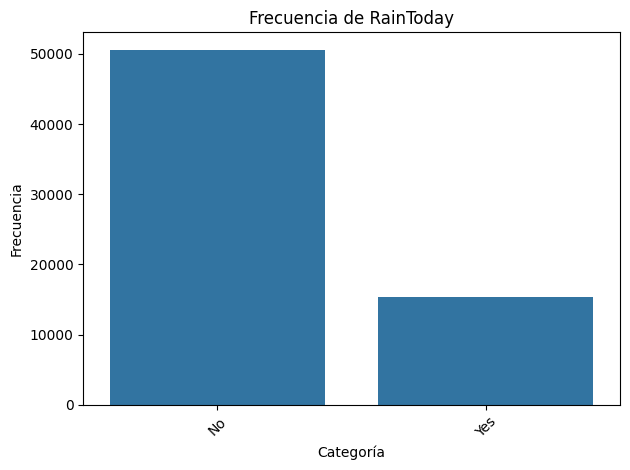

In [ ]:
graficar_frecuencia('RainToday')

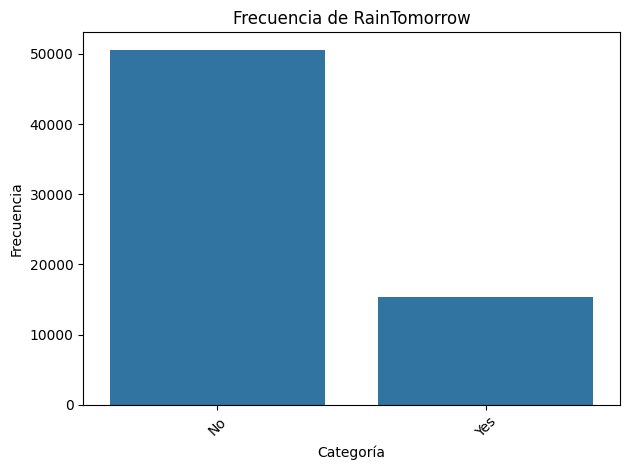

In [ ]:
graficar_frecuencia('RainTomorrow')

Tanto `RainToday` como `RainTomorrow` son variables binarias, convertimos sus valores a 0 y 1.


In [ ]:
ds['RainToday'] = ds['RainToday'].map({'No':0,'Yes':1})
ds['RainTomorrow'] = ds['RainTomorrow'].map({'No':0,'Yes':1})

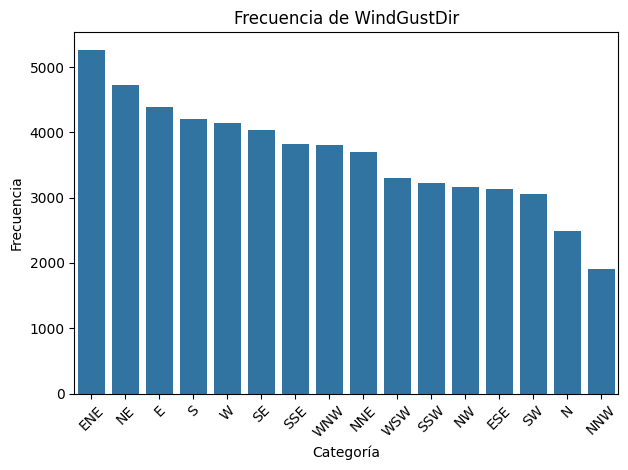

In [ ]:
graficar_frecuencia('WindGustDir')

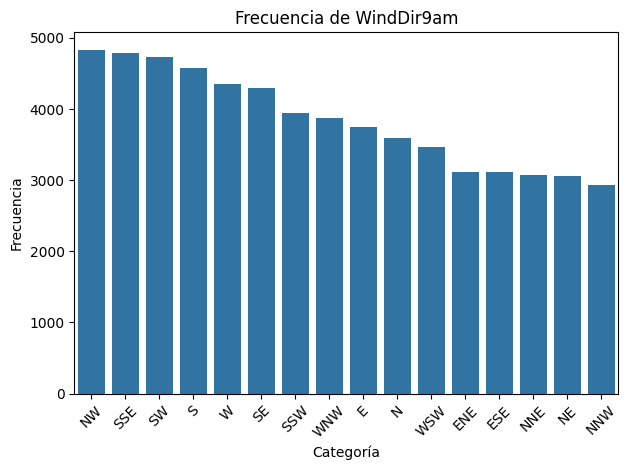

In [ ]:
graficar_frecuencia('WindDir9am')

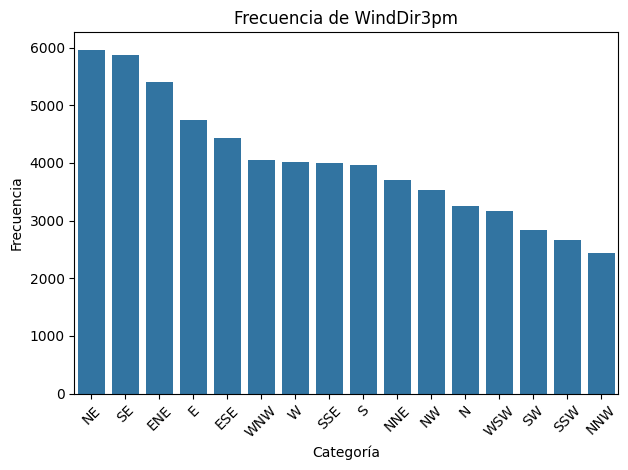

In [ ]:
graficar_frecuencia('WindDir3pm')

Fechas a formato numérico

In [ ]:
ds['Date'].value_counts()

Date
2017-06-24    22
2017-06-23    22
2017-06-22    22
2017-06-21    22
2017-06-20    22
              ..
2007-12-26     1
2007-12-27     1
2008-01-29     1
2008-01-30     1
2008-01-31     1
Name: count, Length: 3436, dtype: int64

In [ ]:
ds["Date"] = pd.to_datetime(ds["Date"])
ds["Year"] = ds["Date"].dt.year
ds["Month"] = ds["Date"].dt.month
ds["Day"] = ds["Date"].dt.day
ds.drop("Date", axis=1, inplace=True)

##### Datos nulos

Analizamos la proporcion de datos nulos de cada atributo

In [ ]:
def print_nan_proportions(col=None):
    filas_totales = ds.shape[0]

    if col is None:
        # Muestra proporción de nulos para todas las columnas
        print(ds.isna().sum() / filas_totales * 100)
    else:
        if col in ds.columns:
            print(ds[col].isna().sum() / filas_totales * 100)
        else:
            print(f"La columna '{col}' no existe en el DataFrame.")

In [ ]:
print_nan_proportions()

Location          0.000000
MinTemp           0.997835
MaxTemp           0.748747
Rainfall          2.292204
Evaporation      49.639712
Sunshine         56.578596
WindGustDir      13.394419
WindGustSpeed    13.385523
WindDir9am        8.805563
WindDir3pm        5.076654
WindSpeed9am      2.096492
WindSpeed3pm      4.018029
Humidity9am       1.831095
Humidity3pm       3.542093
Pressure9am      14.877087
Pressure3pm      14.802953
Cloud9am         39.355929
Cloud3pm         41.157370
Temp9am           1.383329
Temp3pm           3.168461
RainToday         2.292204
RainTomorrow      2.290721
Year              0.000000
Month             0.000000
Day               0.000000
dtype: float64


### Pre-procesamiento

##### Análisis de los datos nulos

RainTomorrow es nuestra variable target, vamos a eliminar todos los registros en los cuales su valor fue Nan, ya que son pocos (menos del 3%) y al tener un valor indefinido no van a ayudar a nuestro modelo a aprender.

In [ ]:
ds = ds[ds['RainTomorrow'].notna()]

In [ ]:
print_nan_proportions("RainToday")

1.2458081060985418


In [ ]:
# Hay una pequena proporcion de nulos en RainToday, los elimino
ds = ds.dropna(subset=['RainToday'])

##### Análisis de valores atìpicos

<Axes: ylabel='Rainfall'>

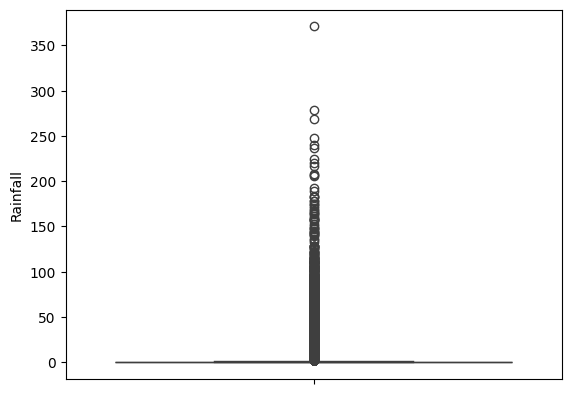

In [ ]:
sns.boxplot(y=ds.Rainfall)

Las variables Cloud son medidas en oktas, solo pueden tomar valores enteros entre 0 y 8, valores fuera de este rango no tienen sentido. Los vamos a imputar más adelante.

In [ ]:
ds.loc[ds['Rainfall'] == max(ds.Rainfall)]

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
9368  CoffsHarbour     17.4     23.1     371.0          NaN       3.5   

     WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Pressure3pm  \
9368         NaN            NaN         SW          S  ...       1025.9   

      Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  Year  \
9368       8.0       5.0     18.6     22.0        1.0           1.0  2009   

      Month  Day  
9368     11    7  

[1 rows x 25 columns]

¿Es 371mm un outlier? Segùn fuentes externas se han registrado valores incluso superiores a 400mm en la region, asi que no es un valor extraño en nuestro analisis.

https://knowledge.aidr.org.au/resources/flood-mid-and-north-coast-new-south-wales/

<Axes: ylabel='Evaporation'>

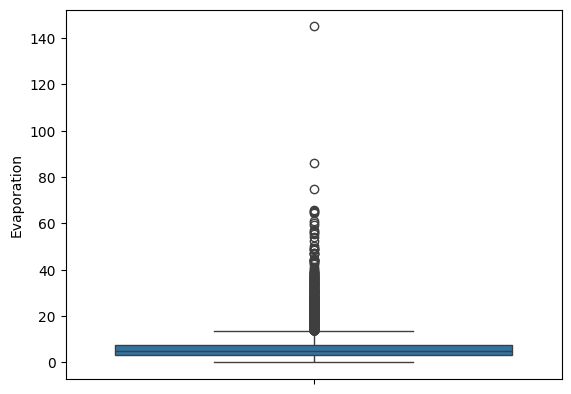

In [ ]:
sns.boxplot(y=ds.Evaporation)

In [ ]:
ds.loc[ds['Evaporation'] == ds['Evaporation'].max()]

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
42358  Williamtown     15.3     23.9      58.2        145.0       NaN   

      WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Pressure3pm  \
42358         NaN            NaN        NaN          E  ...       1017.0   

       Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  Year  \
42358       8.0       1.0     19.1     23.0        1.0           0.0  2016   

       Month  Day  
42358     12   19  

[1 rows x 25 columns]

In [ ]:
indices_top_10_evaporation = ds['Evaporation'].nlargest(10).index
ds.loc[indices_top_10_evaporation]

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
42358    Williamtown     15.3     23.9      58.2        145.0       NaN   
8831           Cobar     19.1     35.3       0.0         86.2       NaN   
23954  NorfolkIsland     19.4     26.1       0.0         74.8       NaN   
8845           Cobar      8.0     28.0       0.4         65.8       NaN   
14616          Moree     14.3     31.0       5.8         65.4      11.2   
6809           Cobar     22.1     39.1       0.0         64.8       NaN   
41294    Williamtown     20.5     28.5       0.0         64.4       NaN   
14449          Moree     16.6     30.7       0.0         60.8       NaN   
14131          Moree     23.1     39.4      15.8         60.2       9.5   
42316    Williamtown     10.1     33.0       0.0         59.2       NaN   

      WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Pressure3pm  \
42358         NaN            NaN        NaN          E  ...       1017.0   
8831          NNW           35.0         NW         NW  ...       1004.6   
23954         ENE           30.0         NE          E  ...       1013.7   
8845           SW           37.0          S         SW  ...       1014.4   
14616         SSE           31.0          E        SSE  ...       1014.5   
6809            N           37.0        NNE        NNW  ...       1011.6   
41294         SSE           41.0          E         SE  ...       1007.3   
14449           E           43.0          E        ESE  ...       1028.2   
14131          SW           54.0        NNE        NNE  ...       1009.1   
42316          NW           44.0         NW        WSW  ...       1006.9   

       Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  Year  \
42358       8.0       1.0     19.1     23.0        1.0           0.0  2016   
8831        NaN       NaN     26.7     34.1        0.0           0.0  2016   
23954       6.0       8.0     23.4     23.6        0.0           1.0  2017   
8845        NaN       NaN     19.0     26.5        0.0           0.0  2016   
14616       1.0       4.0     21.5     29.2        1.0           0.0  2016   
6809        0.0       1.0     30.1     36.9        0.0           0.0  2011   
41294       3.0       4.0     25.6     26.9        0.0           0.0  2014   
14449       0.0       0.0     20.7     29.1        0.0           0.0  2015   
14131       2.0       5.0     29.2     38.0        1.0           0.0  2014   
42316       NaN       NaN     20.2     32.2        0.0           0.0  2016   

       Month  Day  
42358     12   19  
8831      11   11  
23954      1    3  
8845      11   25  
14616      3   23  
6809       1   31  
41294      1   20  
14449     10    8  
14131     11   24  
42316     11    7  

[10 rows x 25 columns]

Un valor de Evaporation de 145mm puede considerarse un outlier en este contexto. Comparado con los demás registros enumerados, es el que tiene el mínimo valor de MaxTemp y el máximo Rainfall. Es una observaciòn que mete un poco de ruido en los datos.

Lo eliminamos:

In [ ]:
ds = ds.drop(index=ds['Evaporation'].idxmax())

No hay inconsistencias de registros que digan que hubo lluvia en dias con Rainfall menor a 1mm.

In [ ]:
ds[(ds['Rainfall'] < 1) & (ds['RainToday'] == "Yes")]

Empty DataFrame
Columns: [Location, MinTemp, MaxTemp, Rainfall, Evaporation, Sunshine, WindGustDir, WindGustSpeed, WindDir9am, WindDir3pm, WindSpeed9am, WindSpeed3pm, Humidity9am, Humidity3pm, Pressure9am, Pressure3pm, Cloud9am, Cloud3pm, Temp9am, Temp3pm, RainToday, RainTomorrow, Year, Month, Day]
Index: []

[0 rows x 25 columns]

A mayor humedad se esperaría menor evaporación. No parece haber valores atipicos en su comparación.

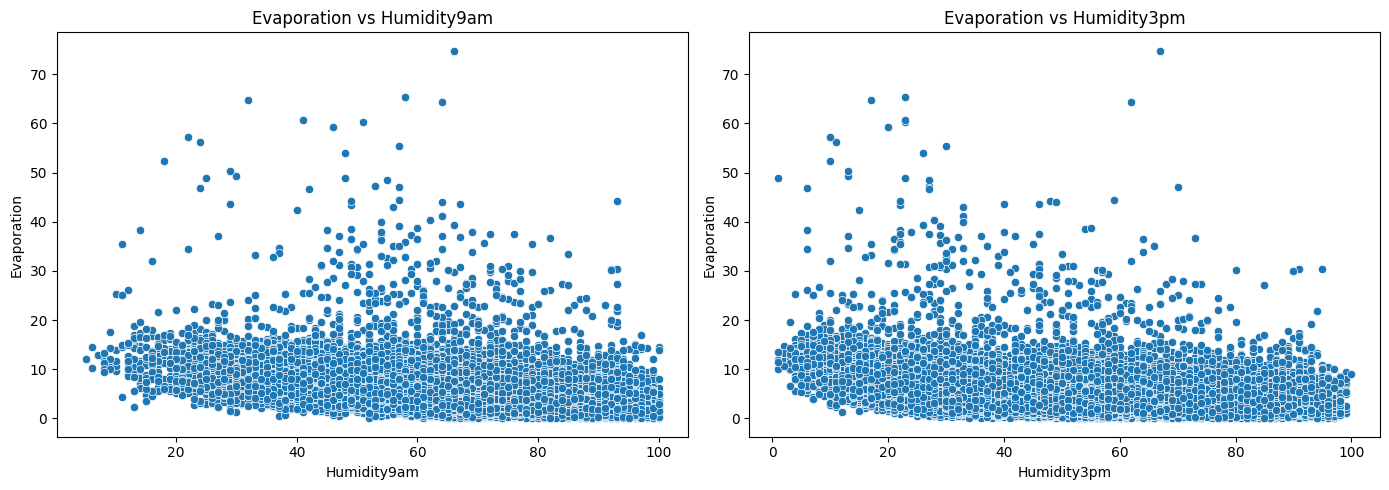

In [ ]:
evaporation_vs_humidity = ds[['Evaporation', 'Humidity9am', 'Humidity3pm']].dropna()

# Crear figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Evaporation vs Humidity9am
sns.scatterplot(data=evaporation_vs_humidity, x='Humidity9am', y='Evaporation', ax=axes[0])
axes[0].set_title('Evaporation vs Humidity9am')

# Evaporation vs Humidity3pm
sns.scatterplot(data=evaporation_vs_humidity, x='Humidity3pm', y='Evaporation', ax=axes[1])
axes[1].set_title('Evaporation vs Humidity3pm')

plt.tight_layout()
plt.show()



Encontramos dos outliers observando los valores de nubosidad.

In [ ]:
ds[(ds['Cloud3pm'] > 8) | (ds['Cloud9am'] > 8) | (ds['Cloud9am'] < 0) | (ds['Cloud3pm'] < 0)]

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
30776    Sydney     17.0     21.8       4.4         11.2       8.0   
47226  Canberra      0.6     14.5       0.0          NaN       7.8   

      WindGustDir  WindGustSpeed WindDir9am WindDir3pm  ...  Pressure3pm  \
30776         NaN            NaN          W          W  ...        997.8   
47226          SW           30.0        NNW        SSW  ...       1020.7   

       Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  RainTomorrow  Year  \
30776       9.0       3.0     17.3     20.9        1.0           0.0  2009   
47226       9.0       NaN      4.4     14.2        0.0           0.0  2012   

       Month  Day  
30776      9   23  
47226      5   27  

[2 rows x 25 columns]

##### Analisis de correlacion entre variables.

In [ ]:
def mostrar_correlaciones(variable):
  campos = ds.columns.tolist()
  correlaciones_sunshine = []

  for campo in campos:
    if not pd.api.types.is_numeric_dtype(ds[campo]):
      continue

    val = ds[variable].corr(ds[campo]).round(2)
    correlaciones_sunshine.append((campo, val))

  correlaciones_sunshine = ordenadas = sorted(correlaciones_sunshine, key=lambda x: -abs(x[1]))

  for campo, val in correlaciones_sunshine:
    print(f"{campo}: {val}")

In [ ]:
mostrar_correlaciones('Sunshine')

Sunshine: 1.0
Cloud3pm: -0.72
Cloud9am: -0.71
Humidity3pm: -0.6
Humidity9am: -0.53
RainTomorrow: -0.48
Temp3pm: 0.39
MaxTemp: 0.36
RainToday: -0.35
Evaporation: 0.28
Rainfall: -0.26
Temp9am: 0.19
WindGustSpeed: -0.07
WindSpeed3pm: 0.07
Month: 0.07
WindSpeed9am: -0.05
Pressure3pm: -0.05
MinTemp: -0.04
Year: 0.02
Pressure9am: 0.01
Day: -0.0


In [ ]:
mostrar_correlaciones('Evaporation')

Evaporation: 1.0
MaxTemp: 0.53
Temp3pm: 0.52
Temp9am: 0.47
Humidity9am: -0.41
MinTemp: 0.4
Sunshine: 0.28
Humidity3pm: -0.27
Pressure3pm: -0.27
Pressure9am: -0.26
WindGustSpeed: 0.21
WindSpeed9am: 0.17
WindSpeed3pm: 0.15
RainToday: -0.15
Year: 0.12
Cloud9am: -0.11
Cloud3pm: -0.1
RainTomorrow: -0.08
Rainfall: -0.05
Month: 0.01
Day: -0.01


In [ ]:
mostrar_correlaciones('WindGustSpeed')

WindGustSpeed: 1.0
WindSpeed3pm: 0.67
WindSpeed9am: 0.58
Pressure9am: -0.39
Pressure3pm: -0.34
Evaporation: 0.21
RainTomorrow: 0.21
MinTemp: 0.18
Humidity9am: -0.17
RainToday: 0.16
Rainfall: 0.15
Temp9am: 0.14
Cloud3pm: 0.12
Cloud9am: 0.08
Sunshine: -0.07
Month: 0.06
MaxTemp: 0.04
Humidity3pm: 0.04
Year: -0.02
Day: -0.02
Temp3pm: 0.01


In [ ]:
mostrar_correlaciones('Cloud3pm')

Cloud3pm: 1.0
Sunshine: -0.72
Cloud9am: 0.6
Humidity3pm: 0.5
RainTomorrow: 0.41
Humidity9am: 0.36
RainToday: 0.27
Temp3pm: -0.22
Rainfall: 0.19
MaxTemp: -0.17
MinTemp: 0.13
WindGustSpeed: 0.12
Pressure9am: -0.12
Evaporation: -0.1
WindSpeed9am: 0.07
Pressure3pm: -0.07
Month: -0.05
Year: 0.04
Temp9am: -0.02
WindSpeed3pm: -0.01
Day: -0.0


In [ ]:
mostrar_correlaciones('Cloud9am')

Cloud9am: 1.0
Sunshine: -0.71
Cloud3pm: 0.6
Humidity3pm: 0.51
Humidity9am: 0.48
RainToday: 0.33
RainTomorrow: 0.33
Rainfall: 0.22
Temp3pm: -0.21
MaxTemp: -0.2
MinTemp: 0.18
Evaporation: -0.11
Pressure9am: -0.1
WindGustSpeed: 0.08
Year: 0.07
Pressure3pm: -0.05
Month: -0.05
WindSpeed9am: 0.04
Temp9am: -0.04
WindSpeed3pm: 0.03
Day: 0.01


Hay una correlación un poco más alta y negativa para Sunshine vs Cloud9am y Cloud3pm. Es de alredodor de -0.7.

Las variables Cloud (como Cloud3pm y Cloud9am) representan la nubosidad en oktas, que solo puede tomar valores enteros entre 0 y 8. Por ello, se consideran variables discretas ordinales, ya que:

- Son discretas → solo toman un conjunto finito de valores.

- Son ordinales → existe un orden natural (0 = cielo despejado, 8 = completamente nublado).

En cambio, la variable Sunshine es continua, puede asumir cualquier valor real dentro de un rango.

Dado este contraste, para observar cómo varía la cantidad de horas de sol en función de los niveles de nubosidad, resulta apropiado utilizar un barplot para representar esta relación:

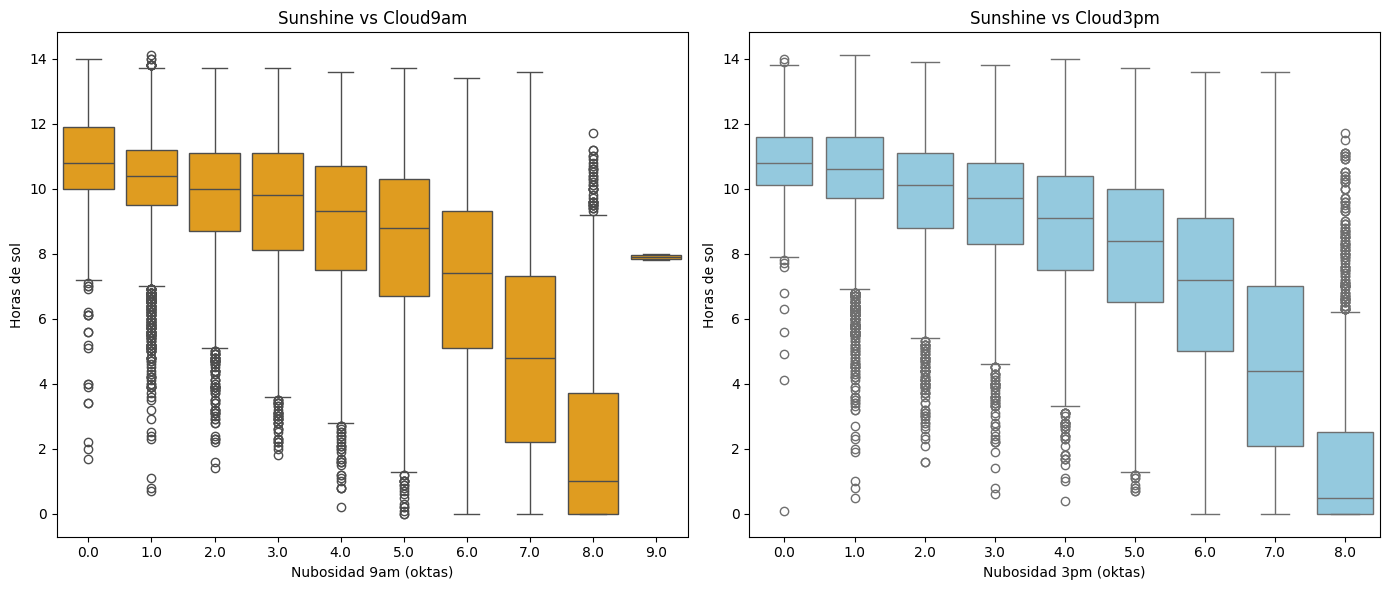

In [ ]:
plt.figure(figsize=(14,6))

# Boxplot para 9am
plt.subplot(1, 2, 1)
sns.boxplot(data=ds, x='Cloud9am', y='Sunshine', color='orange')
plt.title('Sunshine vs Cloud9am')
plt.xlabel('Nubosidad 9am (oktas)')
plt.ylabel('Horas de sol')

# Boxplot para 3pm
plt.subplot(1, 2, 2)
sns.boxplot(data=ds, x='Cloud3pm', y='Sunshine', color='skyblue')
plt.title('Sunshine vs Cloud3pm')
plt.xlabel('Nubosidad 3pm (oktas)')
plt.ylabel('Horas de sol')

plt.tight_layout()
plt.show()


Imputamos los outliers de 9 oktas a 6 oktas. Tomamos esta decisión basados en que la cantidad de horas de sol está cercano a la mediana de los registros de 6 oktas, como se puede observar en el gráfico de la izquierda.

In [ ]:
ds.loc[ds['Cloud9am'] > 8, 'Cloud9am'] = 6

Basándonos en la relación entre horas de sol y nubosidad, observamos que para 6 y 7 oktas las mediciones de horas de sol presentan baja dispersión. Por ello, podemos imputar los valores faltantes de Sunshine correspondientes a estas nubosidades usando la mediana (o promedio) de las horas de sol registradas, asegurando que los valores imputados sean razonables. Esta estrategia permitiría cubrir hasta un 13% de los registros con valores de Sunshine faltantes.

In [ ]:
# Filtramos registros de interés
filtro_cloud_3pm = ds[(ds['Sunshine'].isna()) & (ds['Cloud3pm'].isin([6,7]))]
filtro_cloud_9am = ds[(ds['Sunshine'].isna()) & (ds['Cloud9am'].isin([6,7]))]

# Cantidades
nan_sunshine = ds['Sunshine'].isna().sum()
print(f"Cantidad de NaN en Sunshine: {nan_sunshine}")
print(f"Cantidad de registros con Sunshine NaN y Cloud3pm en [6,7]: {filtro_cloud_3pm.shape[0]}")
print(f"Cantidad de registros con Sunshine NaN y Cloud9am en [6,7]: {filtro_cloud_9am.shape[0]}")

# Registros "imputables"
filtro_sunshine_imputables = ds[(ds['Sunshine'].isna()) &
                                (ds['Cloud3pm'].isin([5,6,7]) | ds['Cloud9am'].isin([6,7]))]
msg_cantidades = f"Cantidad de registros con Sunshine NaN imputables por nubosidad: {filtro_sunshine_imputables.shape[0]}"
proporcion = (filtro_sunshine_imputables.shape[0] * 100 / nan_sunshine).round(2)
print(f"\n{msg_cantidades} ({proporcion}% de los Nan totales)")

Cantidad de NaN en Sunshine: 35931
Cantidad de registros con Sunshine NaN y Cloud3pm en [6,7]: 2335
Cantidad de registros con Sunshine NaN y Cloud9am en [6,7]: 2731

Cantidad de registros con Sunshine NaN imputables por nubosidad: 4792 (13.34% de los Nan totales)


##### Imputación de valores

###### Distribuciones de las variables antes de imputar

Variables con mayor cantidad de datos nulos:

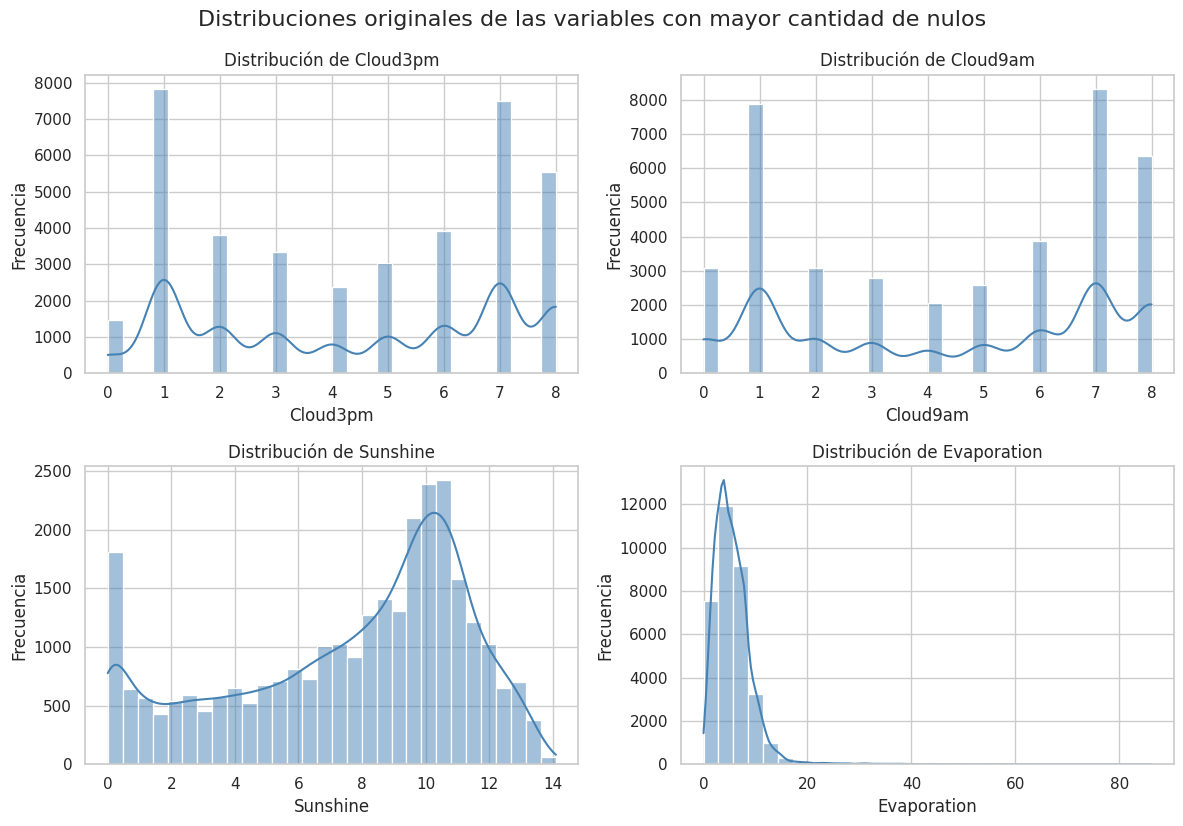

In [ ]:
vars_con_nulos = ["Cloud3pm", "Cloud9am", "Sunshine", "Evaporation"]

# Configurar layout
n_cols = 2
n_rows = 2

plt.figure(figsize=(6 * n_cols, 4 * n_rows))
sns.set(style="whitegrid")

for i, col in enumerate(vars_con_nulos, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(ds[col], kde=True, bins=30, color='steelblue')
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.suptitle('Distribuciones originales de las variables con mayor cantidad de nulos', fontsize=16, y=1.03)
plt.show()

Todas las variables:

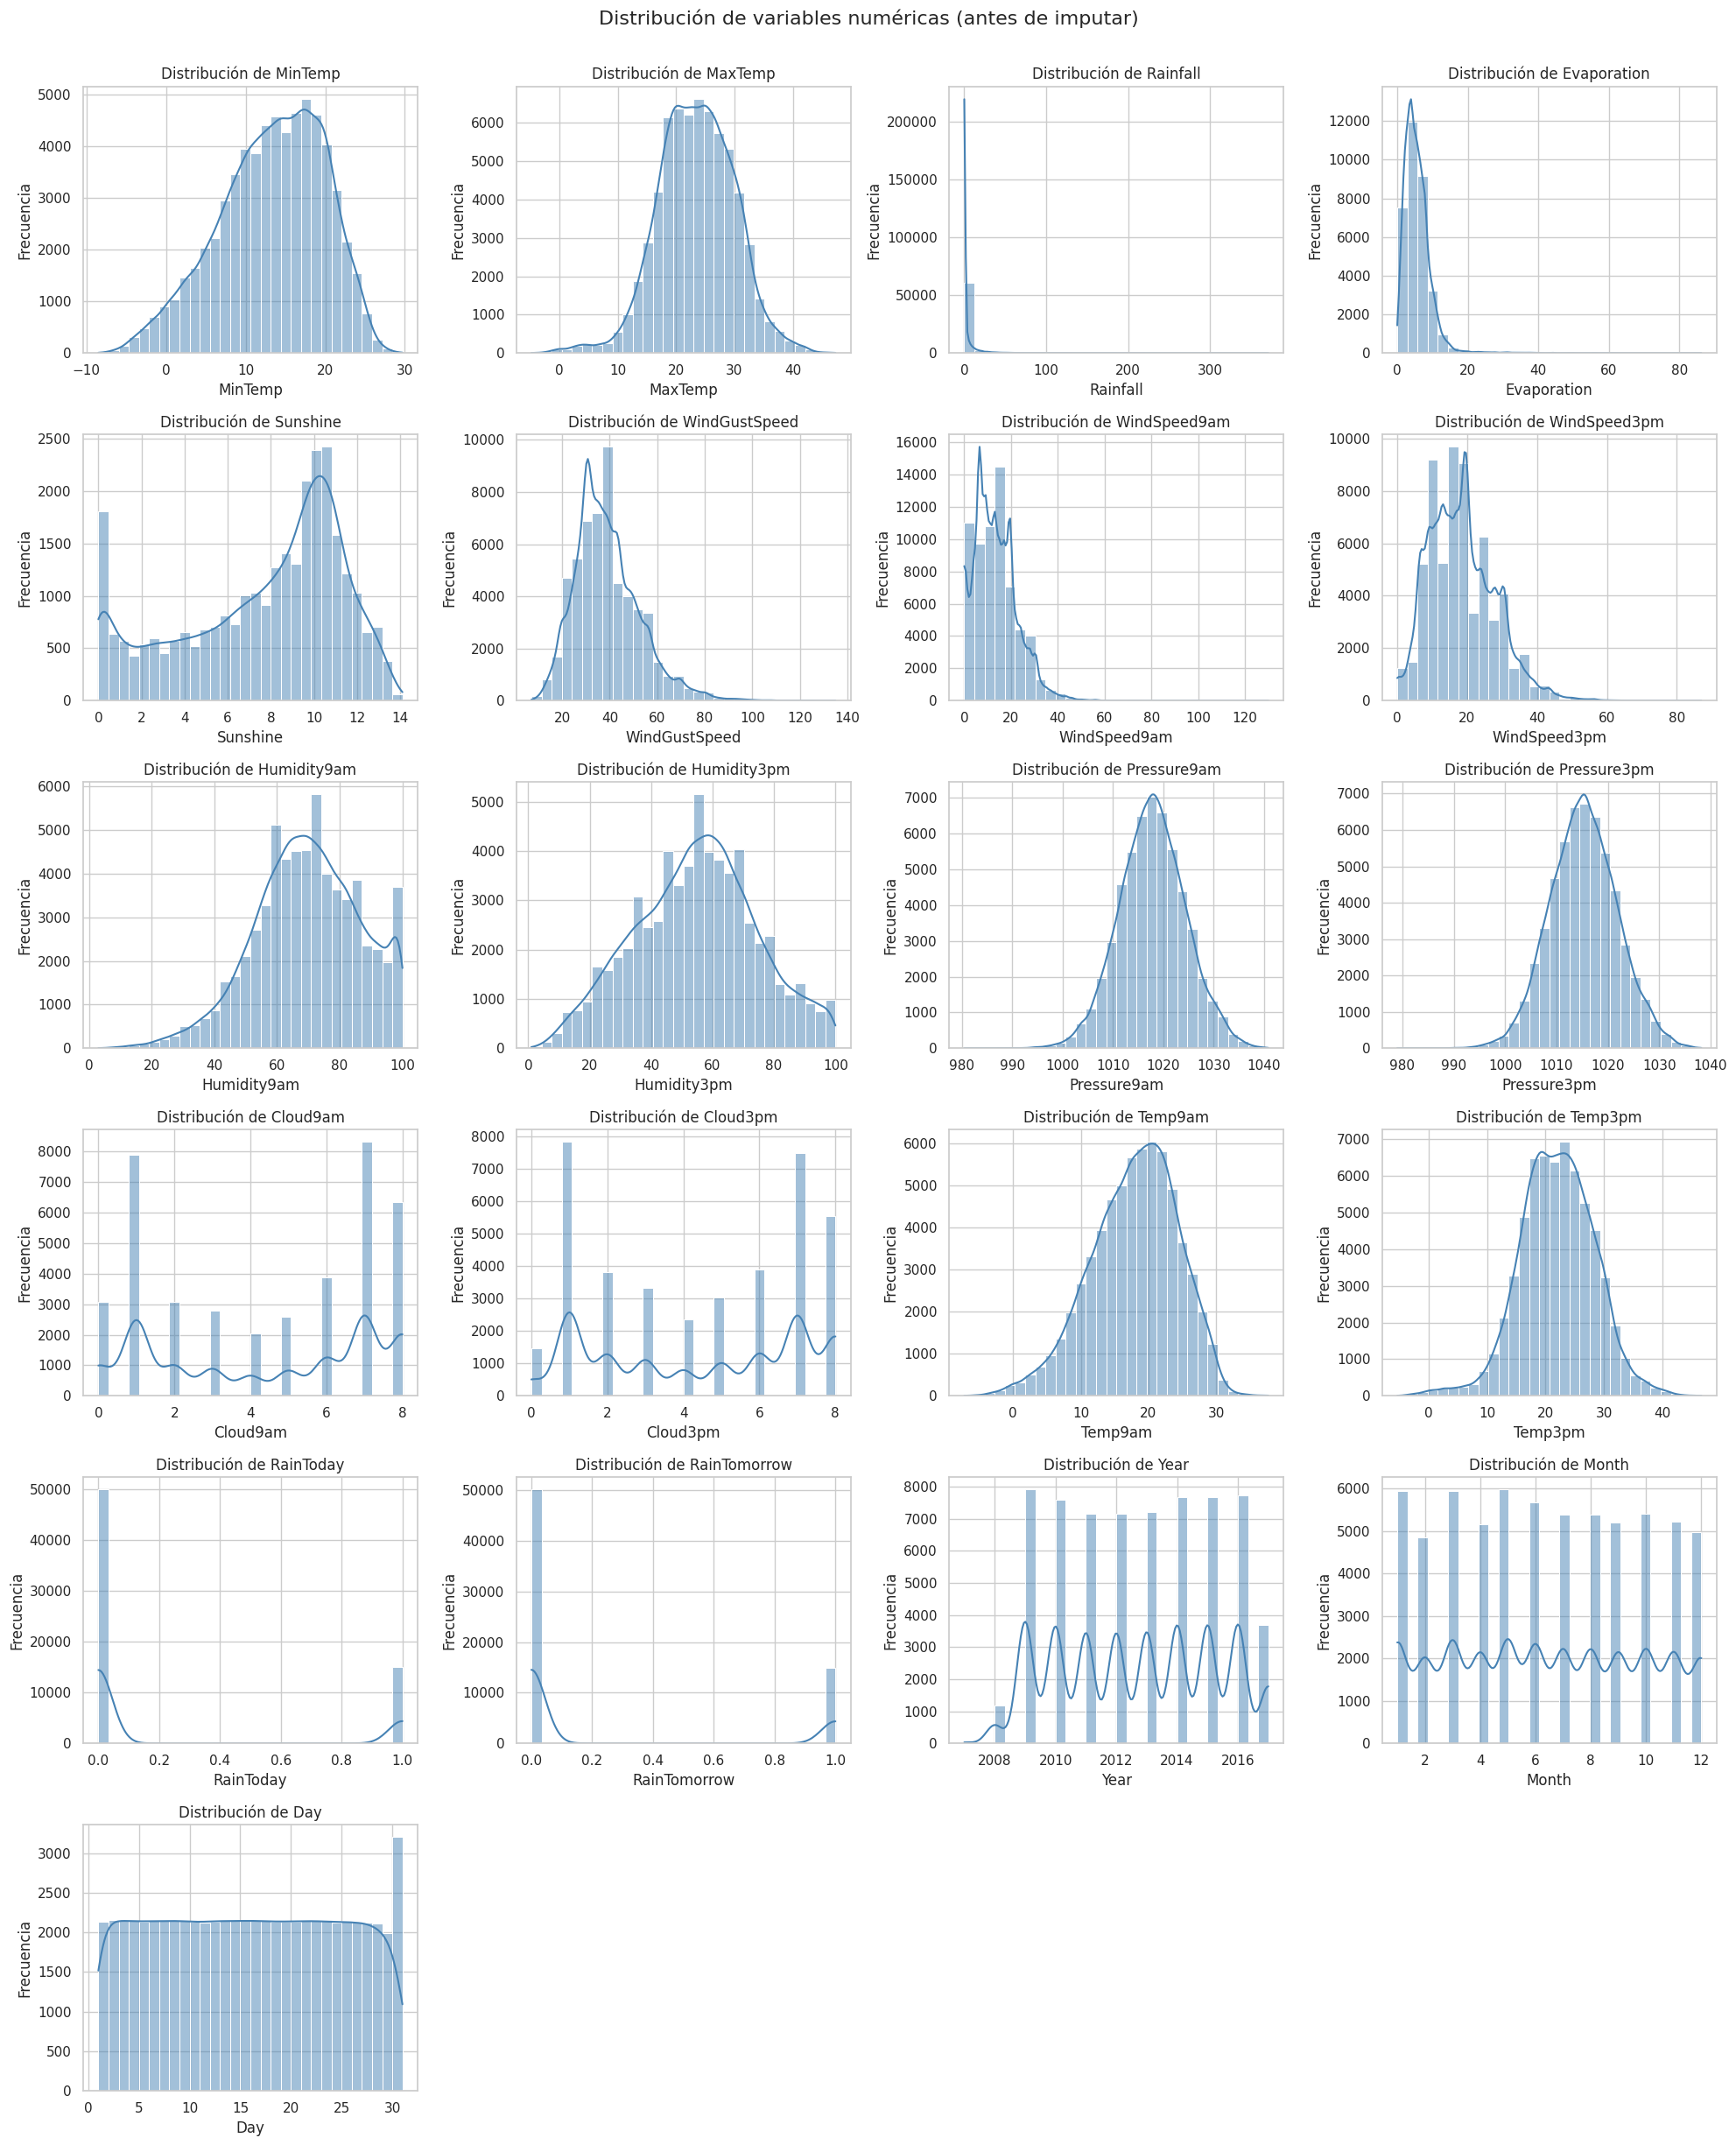

In [ ]:
# Seleccionar columnas numéricas
numeric_cols = ds.select_dtypes(include='number').columns.tolist()

# Configurar layout
n_cols = 4  # cantidad de gráficos por fila
n_rows = -(-len(numeric_cols) // n_cols)  # ceil division

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(ds[col], kde=True, bins=30, color='steelblue')
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.suptitle('Distribución de variables numéricas (antes de imputar)', fontsize=16, y=1.02)
plt.show()

###### Imputación

Imputación por KNN para las variables con mayor cantidad de datos faltantes.

In [ ]:
# Variables auxiliares con alta correlación
vars_auxiliares = ['WindSpeed3pm', 'WindSpeed9am', 'Pressure9am']

# Subset para imputación
subset = ds[['WindGustSpeed'] + vars_auxiliares]

# Aplicar KNNImputer
imputer = KNNImputer(n_neighbors=5)
subset_imputado_wind = imputer.fit_transform(subset)

In [ ]:
# Variables auxiliares con alta correlación
vars_auxiliares = ['MaxTemp', 'Temp3pm', 'Temp9am', 'Humidity9am', 'MinTemp']

# Subset para imputación
subset = ds[['Evaporation'] + vars_auxiliares]

# Aplicar KNNImputer
imputer = KNNImputer(n_neighbors=5)
subset_imputado_evaporation = imputer.fit_transform(subset)

In [ ]:
# Variables auxiliares con alta correlación
vars_auxiliares_sunshine = ['Cloud3pm', 'Cloud9am', 'Humidity3pm', 'Humidity9am',
                            'RainTomorrow']

# Subset para imputación
subset = ds[['Sunshine'] + vars_auxiliares_sunshine]

# Aplicar KNNImputer
imputer = KNNImputer(n_neighbors=5)
subset_imputado_sunshine = imputer.fit_transform(subset)

Imputación para valores de Cloud. Usando random forest y features con correlaciones más fuertes.

In [ ]:
def predecir_cloud_rf_completo(ds_cloud, target, features, seed=42):
    # Subset sin nulos en target y features
    df_train = ds_cloud.dropna(subset=[target] + features)
    X_train = df_train[features]
    y_train = df_train[target].astype(int)

    # Entrenar clasificador
    clf = RandomForestClassifier(n_estimators=100, random_state=seed)
    clf.fit(X_train, y_train)

    # Máscara: target nulo y features completos → imputables por RF
    mask_rf = ds_cloud[target].isna() & ds_cloud[features].notna().all(axis=1)
    X_pred = ds_cloud.loc[mask_rf, features]
    pred_rf = clf.predict(X_pred)

    # Crear DataFrame con imputaciones por RF
    df_rf = pd.DataFrame({
        'index': X_pred.index,
        f'{target}_imputado': pred_rf,
        'metodo': 'rf'
    }).set_index('index')

    # Máscara: target nulo y features incompletos → imputar por moda
    mask_moda = ds_cloud[target].isna() & ~mask_rf
    moda_global = ds_cloud[target].mode().iloc[0]
    df_moda = pd.DataFrame({
        'index': ds_cloud.loc[mask_moda].index,
        f'{target}_imputado': moda_global,
        'metodo': 'moda'
    }).set_index('index')

    # Combinar ambas imputaciones
    df_imputaciones = pd.concat([df_rf, df_moda]).sort_index()

    # Reporte
    print(f"{target}: imputables por RF = {len(df_rf)}, por moda = {len(df_moda)}. Total = {len(df_imputaciones)}")
    return df_imputaciones

# Hay una fuerte correlacion con Sunshine, pero tiene muchos nulos
# lo que hace que la mayor parte de las imputaciones sea por moda,
# lo que mete mucho ruido a la distribucion

# Posible mejora: No meter nada por moda, lo que quede nulo ignorarlo.

# Predecir valores para imputar Cloud3pm
cloud3pm_imputaciones = predecir_cloud_rf_completo(ds, 'Cloud3pm', ['Humidity3pm', 'Humidity9am', 'RainTomorrow'])

cloud9am_imputaciones = predecir_cloud_rf_completo(
    ds,
    target='Cloud9am',
    features=['Humidity3pm', 'Humidity9am'],
    seed=42
)

Cloud3pm: imputables por RF = 24122, por moda = 2196. Total = 26318
Cloud9am: imputables por RF = 24256, por moda = 820. Total = 25076


In [ ]:
# Reemplazar Sunshine en el DataFrame original
ds.loc[:, 'Sunshine'] = subset_imputado_sunshine[:, 0]

# Reemplazar Sunshine en el DataFrame original
ds.loc[:, 'Evaporation'] = subset_imputado_evaporation[:, 0]

# Reemplazar Sunshine en el DataFrame original
ds.loc[:, 'WindGustSpeed'] = subset_imputado_wind[:, 0]


# Aplicar imputaciones
ds.loc[cloud3pm_imputaciones.index, 'Cloud3pm'] = cloud3pm_imputaciones['Cloud3pm_imputado']
ds['Cloud3pm'] = ds['Cloud3pm'].astype('Int64')

ds.loc[cloud9am_imputaciones.index, 'Cloud9am'] = cloud9am_imputaciones['Cloud9am_imputado']
ds['Cloud9am'] = ds['Cloud9am'].astype('Int64')

Imputo variables cuantitativas por mediana, cualitativas por moda.

In [ ]:
cuantitativas_imp_por_mes = ['Pressure9am', 'Pressure3pm', 'Temp3pm',
                      'Humidity3pm']

imputadas = ['Evaporation', 'Sunshine', 'WindGustSpeed', 'Cloud3pm', 'Cloud9am']

# Imputamos valores faltantes en columnas cuantitativas por la mediana.
for col in cuantitativas:
  if not (col in cuantitativas_imp_por_mes or col in imputadas):
    ds.loc[:, col] = ds[col].fillna(ds[col].median())

# Imputación condicional por Month
for col in cuantitativas_imp_por_mes:
    # Imputar por mediana dentro de cada mes
    ds.loc[:, col] = ds.groupby('Month')[col].transform(lambda x: x.fillna(x.median()))

    # Fallback: si aún quedan nulos, imputar por mediana global
    ds.loc[:, col] = ds[col].fillna(ds[col].median())


###### Distribución de las variables luego de imputar valores

Variables con mayor cantidad de datos nulos:

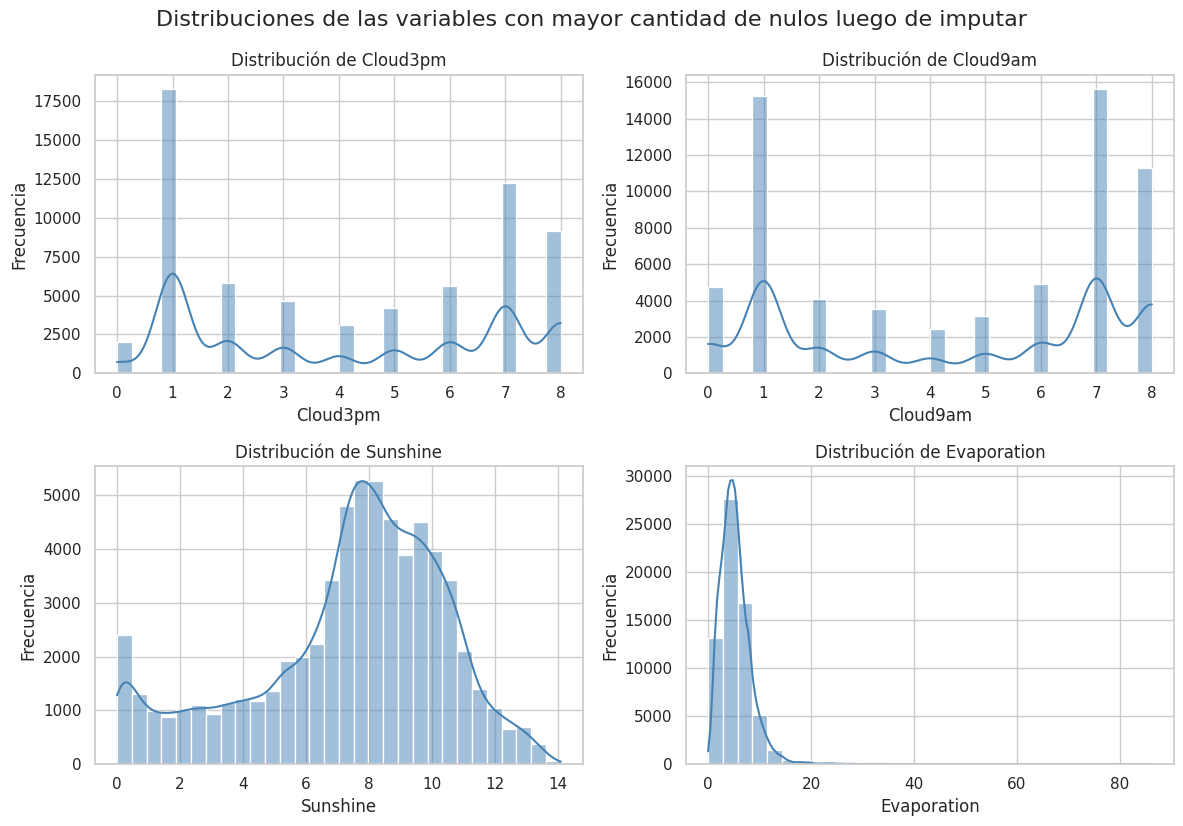

In [ ]:
vars_con_nulos = ["Cloud3pm", "Cloud9am", "Sunshine", "Evaporation"]

# Configurar layout
n_cols = 2
n_rows = 2

plt.figure(figsize=(6 * n_cols, 4 * n_rows))
sns.set(style="whitegrid")

for i, col in enumerate(vars_con_nulos, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(ds[col], kde=True, bins=30, color='steelblue')
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.suptitle('Distribuciones de las variables con mayor cantidad de nulos luego de imputar', fontsize=16, y=1.03)
plt.show()

Todas las variables:

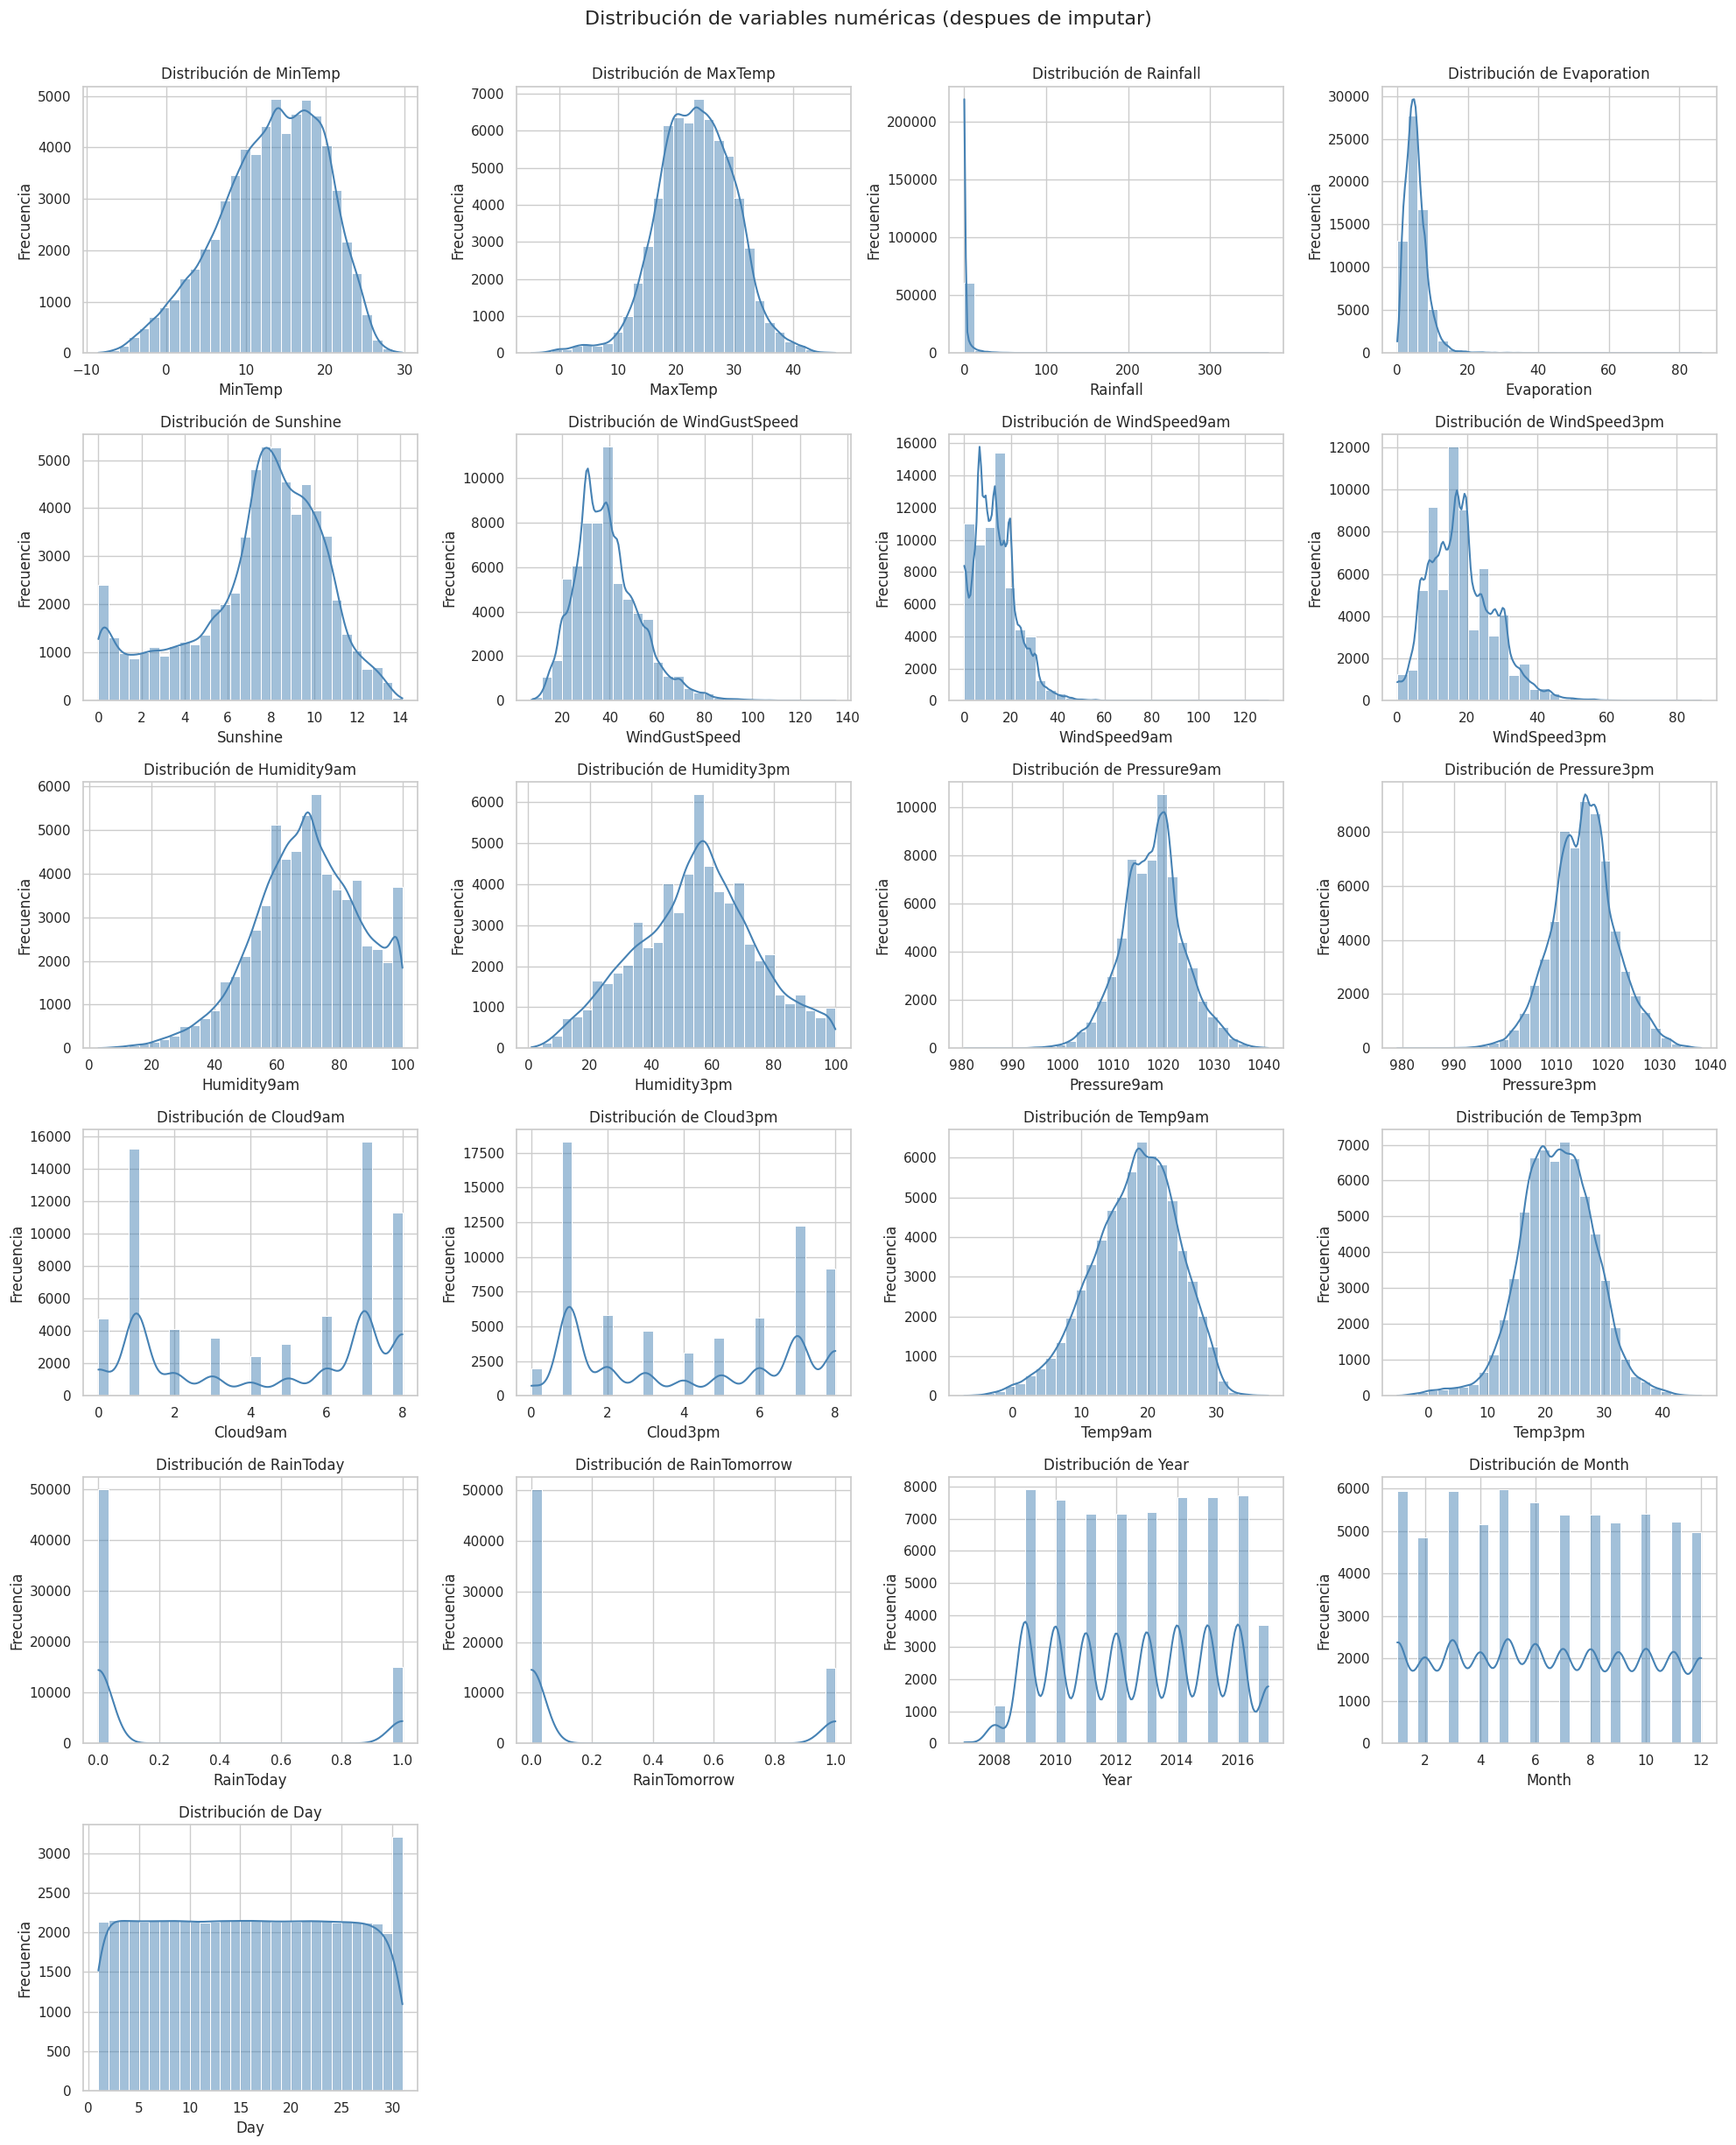

In [ ]:
# Seleccionar columnas numéricas
numeric_cols = ds.select_dtypes(include='number').columns.tolist()

# Configurar layout
n_cols = 4  # cantidad de gráficos por fila
n_rows = -(-len(numeric_cols) // n_cols)  # ceil division

plt.figure(figsize=(5 * n_cols, 4 * n_rows))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(ds[col], kde=True, bins=30, color='steelblue')
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')

plt.tight_layout()
plt.suptitle('Distribución de variables numéricas (despues de imputar)', fontsize=16, y=1.02)
plt.show()

###### Encoding

Para entrenar nuestros modelos de clasificación, vamos a necesitar convertir las variables de texto en valores numéricos, ya que la mayoría de los algoritmos de machine learning no pueden procesar directamente datos categóricos en formato textual.

En este dataset las variables a convertir son Location, WindGustDir, WindDir9am, WindDir3pm, RainToday, RainTomorrow.

###### **Transformaciones previas**
Para reducir la dimensionalidad del problema se realizaron previo al encoding algunas transformaciones sobre el dataset

Clasifico a las variables de viento según la orientación de su dirección + OneHotEncoding

In [ ]:
# Diccionario de agrupamiento
orientacion_map = {
    'N': ['N', 'NNE', 'NE'],
    'E': ['ENE', 'E', 'ESE'],
    'S': ['SE', 'SSE', 'S', 'SSW', 'SW'],
    'W': ['WSW', 'W', 'WNW', 'NW', 'NNW']
}

def agrupar_orientacion(direccion):
    for grupo, miembros in orientacion_map.items():
        if direccion in miembros:
            return grupo
    return np.nan

In [ ]:
ds['WindGustDir'] = ds['WindGustDir'].apply(agrupar_orientacion)
ds['WindDir3pm'] = ds['WindDir3pm'].apply(agrupar_orientacion)
ds['WindDir9am'] = ds['WindDir9am'].apply(agrupar_orientacion)

El dataset original incluye a una variable categórica `Location`, compuesta por múltiples localidades específicas. Dado que estas localidades se agrupan naturalmente en tres ciudades principales, se decidió consolidarlas en una nueva variable `City`.

In [ ]:
def location_to_city(location):
  if location in locations1:
    return "Territorio de la capital"
  elif location in locations2:
    return "Queensland"
  elif location in locations3:
    return "Nueva Gales del sur"
  return None

In [ ]:
ds["City"] = ds["Location"].apply(location_to_city)
ds.drop("Location", axis=1, inplace=True) # Pasa a ser redundante

###### **OneHotEncoding**

Vamos a codificar a las variables City y Wind mediante One-Hot Encoding, dado que no existe una relación ordinal entre ninguno de sus valores dentro de sus categorías.

In [ ]:
ds = pd.get_dummies(ds, columns=['City'], drop_first=True, dtype=int)
ds = pd.get_dummies(ds, columns=['WindGustDir'], drop_first=True, dtype=int)
ds = pd.get_dummies(ds, columns=['WindDir9am'], drop_first=True, dtype=int)
ds = pd.get_dummies(ds, columns=['WindDir3pm'], drop_first=True, dtype=int)

### Dataset pre-procesado

In [ ]:
# ds.to_csv('ds_imputado.csv', index=False)

In [ ]:
!gdown --id 1Kf9L-DWK1r86vwZC6trYY6vmUFAHMc_V

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Kf9L-DWK1r86vwZC6trYY6vmUFAHMc_V
To: /content/weatherAUS_procesado.csv
100% 7.85M/7.85M [00:00<00:00, 18.1MB/s]


In [ ]:
ds_original = pd.read_csv('weatherAUS_procesado.csv')
ds = ds_original.copy()

Algunos registros:

In [ ]:
ds.head(5)

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
0     13.4     22.9       0.6         5.24      7.18           44.0   
1      7.4     25.1       0.0         8.76      7.12           44.0   
2     12.9     25.7       0.0         6.76      8.12           46.0   
3      9.2     28.0       0.0        19.92      7.76           24.0   
4     17.5     32.3       1.0         6.64      7.38           41.0   

   WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  \
0          20.0          24.0         71.0         22.0  ...   
1           4.0          22.0         44.0         25.0  ...   
2          19.0          26.0         38.0         30.0  ...   
3          11.0           9.0         45.0         16.0  ...   
4           7.0          20.0         82.0         33.0  ...   

   City_Territorio de la capital  WindGustDir_N  WindGustDir_S  WindGustDir_W  \
0                              0              0              0              1   
1                              0              0              0              1   
2                              0              0              0              1   
3                              0              1              0              0   
4                              0              0              0              1   

   WindDir9am_N  WindDir9am_S  WindDir9am_W  WindDir3pm_N  WindDir3pm_S  \
0             0             0             1             0             0   
1             0             0             1             0             0   
2             0             0             1             0             0   
3             0             1             0             0             0   
4             0             0             0             0             0   

   WindDir3pm_W  
0             1  
1             1  
2             1  
3             0  
4             1  

[5 rows x 32 columns]

### Modelo 1: Árbol de decisión

In [ ]:
# Trabajamos en este modelo sobre una copia.
ds_m1 = ds.copy()

##### Set entrenamiento y test

In [ ]:
# Creo un dataset con los features que voy a usar para clasificar
ds_m1_x = ds_m1.drop(['RainTomorrow'], axis='columns', inplace=False)

# Creo un dataset con la variable target
ds_m1_y = ds_m1['RainTomorrow'].copy()

#Genero los conjuntos de train y de test
SEED = 42
x_m1_train, x_m1_test, y_m1_train, y_m1_test = train_test_split(ds_m1_x,
                                                    ds_m1_y,
                                                    test_size=0.2,  #proporcion 80/20
                                                    random_state=SEED, #semilla
                                                    stratify=ds_m1_y.values) #proporcion de clases en los sets

In [ ]:
# Verifico Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_m1_train)))
print('# Datos Prueba: {}'.format(len(x_m1_test)))

# Datos Entrenamiento: 52063
# Datos Prueba: 13016


Mostramos algunos registros de cada set

In [ ]:
x_m1_train.head(2)

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
45361     13.0     24.7      11.4          4.3      9.44           37.0   
41107     -0.6     14.0       0.0          1.2      7.10           41.0   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  \
45361          15.0          13.0         72.0         43.0  ...   
41107           2.0          22.0         86.0         59.0  ...   

       City_Territorio de la capital  WindGustDir_N  WindGustDir_S  \
45361                              1              0              0   
41107                              1              0              0   

       WindGustDir_W  WindDir9am_N  WindDir9am_S  WindDir9am_W  WindDir3pm_N  \
45361              0             0             1             0             0   
41107              1             0             0             1             0   

       WindDir3pm_S  WindDir3pm_W  
45361             1             0  
41107             0             1  

[2 rows x 31 columns]

In [ ]:
y_m1_train.head(2)

45361    0.0
41107    0.0
Name: RainTomorrow, dtype: float64

In [ ]:
x_m1_test.head(2)

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
10253     24.6     35.0       0.0         7.20      8.50           52.0   
902        4.3      9.2       4.2         1.32      3.76           28.0   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  \
10253          17.0          39.0         55.0         63.0  ...   
902            13.0          19.0         94.0         87.0  ...   

       City_Territorio de la capital  WindGustDir_N  WindGustDir_S  \
10253                              0              1              0   
902                                0              0              0   

       WindGustDir_W  WindDir9am_N  WindDir9am_S  WindDir9am_W  WindDir3pm_N  \
10253              0             0             0             1             1   
902                1             0             0             1             0   

       WindDir3pm_S  WindDir3pm_W  
10253             0             0  
902               0             1  

[2 rows x 31 columns]

In [ ]:
y_m1_test.head(2)

10253    0.0
902      0.0
Name: RainTomorrow, dtype: float64

##### Búsqueda de hiperparámetros

In [ ]:
#Cantidad de combinaciones a probar
n=50

#Conjunto de parámetros a utilizar
params_grid = {'criterion':['gini','entropy'],
               'min_samples_leaf':list(range(20,80)),
               'min_samples_split': list(range(20,80)),
               'ccp_alpha':np.linspace(0,0.005,n),
               'max_depth':list(range(5,80)),
               }

#Cantidad de splits para el Cross Validation
folds=5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier(random_state=SEED, class_weight='balanced')

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(f1_score)
# scorer_fn = 'recall' # Empeora el score

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params_grid,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n,
                              random_state=SEED)

Entrenamiento:

In [ ]:
randomcv.fit(x_m1_train,y_m1_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=DecisionTreeClassifier(class_weight='balanced',
                                                    random_state=42),
                   n_iter=50,
                   param_distributions={'ccp_alpha': array([0.        , 0.00010204, 0.00020408, 0.00030612, 0.00040816,
       0.0005102 , 0.00061224, 0.00071429, 0.00081633, 0.00091837,
       0.00102041, 0.00112245, 0.00122449, 0.00132653...
                                                      19, 20, 21, 22, 23, 24,
                                                      25, 26, 27, 28, 29, 30,
                                                      31, 32, 33, 34, ...],
                                        'min_samples_leaf': [20, 21, 22, 23, 24,
                                                             25, 26, 27, 28, 29,
                                                             30, 31, 32, 33, 34,
                                                             35, 36, 37, 38, 39,
                                                             40, 41, 42, 43, 44,
                                                             45, 46, 47, 48, 49, ...],
                                        'min_samples_split': [20, 21, 22, 23,
                                                              24, 25, 26, 27,
                                                              28, 29, 30, 31,
                                                              32, 33, 34, 35,
                                                              36, 37, 38, 39,
                                                              40, 41, 42, 43,
                                                              44, 45, 46, 47,
                                                              48, 49, ...]},
                   random_state=42,
                   scoring=make_scorer(f1_score, response_method='predict'))

In [ ]:
modelo_dt = randomcv.best_estimator_ # dt -> decision tree

Mejores hiperparámetros del modelo:

In [ ]:
print(randomcv.best_params_)

{'min_samples_split': 72, 'min_samples_leaf': 65, 'max_depth': 55, 'criterion': 'gini', 'ccp_alpha': np.float64(0.00020408163265306123)}


Importancia de los parámetros

In [ ]:
sorted(list(zip(ds_m1.columns.to_list(), modelo_dt.feature_importances_)), key = lambda x: -x[1])

[('Sunshine', np.float64(0.7638668180190078)),
 ('Humidity3pm', np.float64(0.07451744396468567)),
 ('Cloud3pm', np.float64(0.056919849833527714)),
 ('Pressure3pm', np.float64(0.025142689608805918)),
 ('WindGustSpeed', np.float64(0.024376004860027656)),
 ('Cloud9am', np.float64(0.01880572016690478)),
 ('Humidity9am', np.float64(0.012514249489369154)),
 ('Rainfall', np.float64(0.0074581052441656534)),
 ('Temp9am', np.float64(0.004823621801905957)),
 ('Pressure9am', np.float64(0.004409681617643184)),
 ('MinTemp', np.float64(0.002489324843683733)),
 ('Temp3pm', np.float64(0.002182599443552378)),
 ('Day', np.float64(0.0015990129357912903)),
 ('Year', np.float64(0.0008948781709290648)),
 ('MaxTemp', np.float64(0.0)),
 ('Evaporation', np.float64(0.0)),
 ('WindSpeed9am', np.float64(0.0)),
 ('WindSpeed3pm', np.float64(0.0)),
 ('RainToday', np.float64(0.0)),
 ('RainTomorrow', np.float64(0.0)),
 ('Month', np.float64(0.0)),
 ('City_Queensland', np.float64(0.0)),
 ('City_Territorio de la capital', 

##### Estructura del modelo

Informe del árbol completo

In [ ]:
variables_independientes = list(x_m1_train.columns)
reglas = export_text(modelo_dt, feature_names=variables_independientes)
print(reglas)

|--- Sunshine <= 6.23
|   |--- Humidity3pm <= 67.50
|   |   |--- Sunshine <= 5.31
|   |   |   |--- Rainfall <= 1.50
|   |   |   |   |--- Pressure3pm <= 1018.65
|   |   |   |   |   |--- Humidity9am <= 74.50
|   |   |   |   |   |   |--- Humidity3pm <= 36.50
|   |   |   |   |   |   |   |--- WindGustSpeed <= 49.00
|   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |   |   |--- WindGustSpeed >  49.00
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |--- Humidity3pm >  36.50
|   |   |   |   |   |   |   |--- Pressure3pm <= 1011.75
|   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |--- Pressure3pm >  1011.75
|   |   |   |   |   |   |   |   |--- City_Queensland <= 0.50
|   |   |   |   |   |   |   |   |   |--- class: 1.0
|   |   |   |   |   |   |   |   |--- City_Queensland >  0.50
|   |   |   |   |   |   |   |   |   |--- class: 0.0
|   |   |   |   |   |--- Humidity9am >  74.50
|   |   |   |   |   |   |--- class: 1.0
|   |   |   | 

Árbol representativo

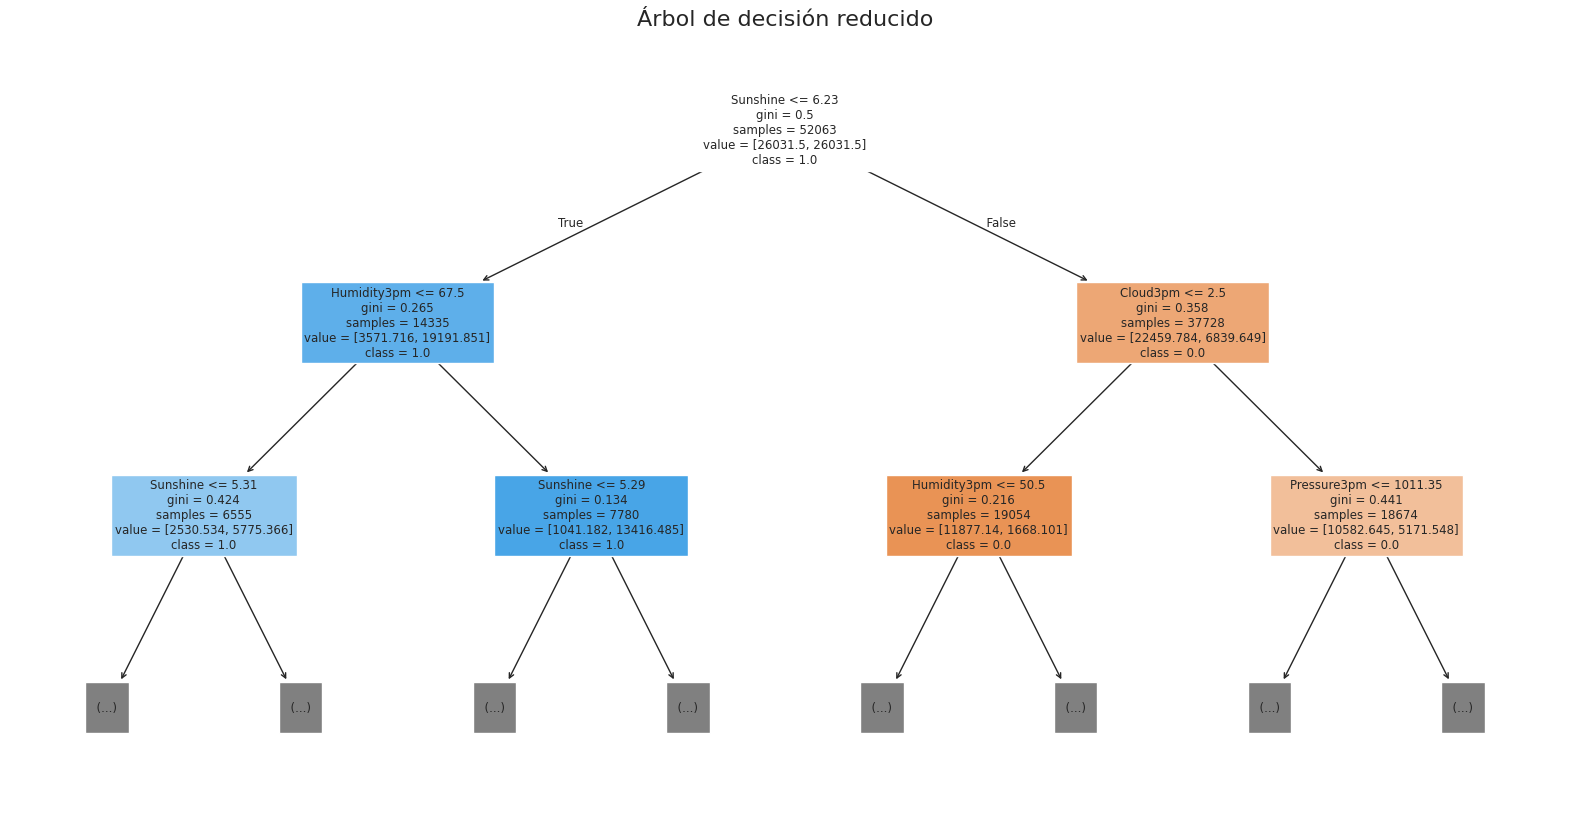

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(
    modelo_dt,
    filled=True,
    feature_names=ds_m1.columns,
    class_names=[str(c) for c in modelo_dt.classes_],
    max_depth=2
)
plt.title("Árbol de decisión reducido", fontsize=16)
plt.show()

##### Evaluación del modelo en TRAIN y TEST

In [ ]:
# TEST
y_m1_test_pred = modelo_dt.predict(x_m1_test)

# TRAIN
y_m1_train_pred = modelo_dt.predict(x_m1_train)

##### Métricas obtenidas

Matrices de confusión

Text(0.5, 1.0, 'Matriz de confusión sobre TEST')

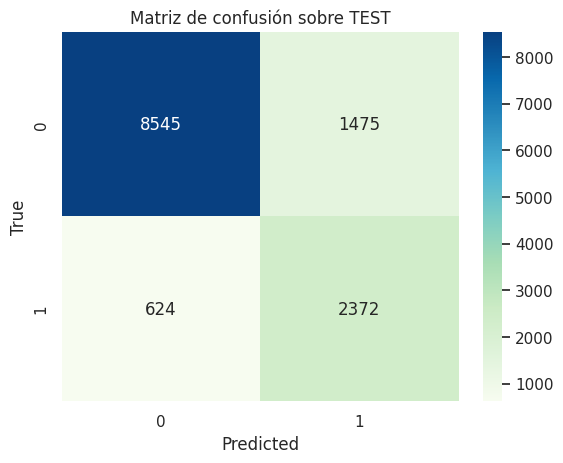

In [ ]:
tabla = confusion_matrix(y_m1_test, y_m1_test_pred)

# Grafico
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Matriz de confusión sobre TEST")

Text(0.5, 1.0, 'Matriz de confusión sobre TRAIN')

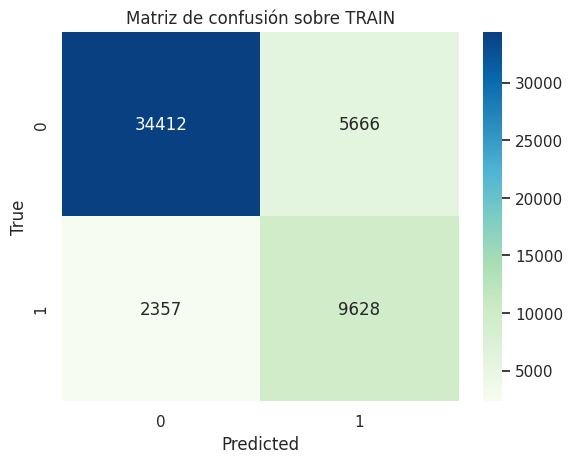

In [ ]:
tabla = confusion_matrix(y_m1_train, y_m1_train_pred)

# La grafico
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Matriz de confusión sobre TRAIN")

Curva ROC

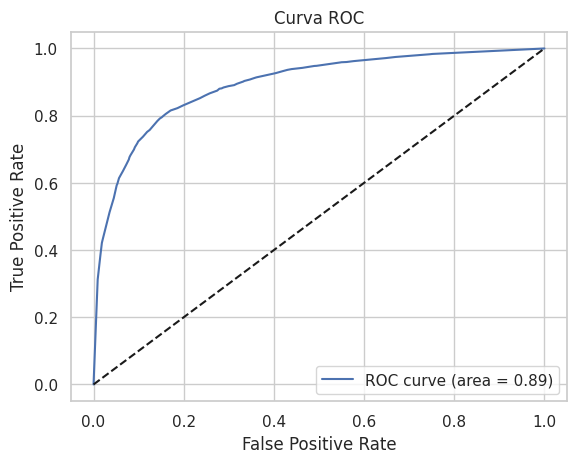

In [ ]:
y_proba = modelo_dt.predict_proba(x_m1_test)[:, 1]
fpr, tpr, _ = roc_curve(y_m1_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

Reportes

In [ ]:
from sklearn.metrics import classification_report

print("🔹 Métricas en TRAIN:")
print(classification_report(y_m1_train, y_m1_train_pred, digits=3))

print("🔹 Métricas en TEST:")
print(classification_report(y_m1_test, y_m1_test_pred, digits=3))

🔹 Métricas en TRAIN:
              precision    recall  f1-score   support

         0.0      0.936     0.859     0.896     40078
         1.0      0.630     0.803     0.706     11985

    accuracy                          0.846     52063
   macro avg      0.783     0.831     0.801     52063
weighted avg      0.865     0.846     0.852     52063

🔹 Métricas en TEST:
              precision    recall  f1-score   support

         0.0      0.932     0.853     0.891     10020
         1.0      0.617     0.792     0.693      2996

    accuracy                          0.839     13016
   macro avg      0.774     0.822     0.792     13016
weighted avg      0.859     0.839     0.845     13016



##### Guardo el modelo

In [ ]:
# Guardar en archivo .pkl
with open("decision_tree.pkl", "wb") as f:
    pickle.dump(modelo_dt, f)

### Modelo 2: Random Forest

In [ ]:
ds_m2 = ds.copy()

##### Set entrenamiento y test

In [ ]:
ds_m2_x = ds_m2.drop(['RainTomorrow'], axis='columns', inplace=False)

ds_m2_y = ds_m2['RainTomorrow'].copy()

SEED = 42
x_m2_train, x_m2_test, y_m2_train, y_m2_test = train_test_split(ds_m2_x,
                                                                ds_m2_y,
                                                                test_size=0.2,  #proporcion 80/20
                                                                random_state=SEED, #semilla
                                                                stratify=ds_m2_y.values) #proporcion de clases en los sets

#RandomOverSampler
ros = RandomOverSampler(sampling_strategy=0.3, random_state=42)
x_m2_train, y_m2_train = ros.fit_resample(x_m2_train, y_m2_train)

print("Distribución tras oversampling en train:")
print(y_m2_train.value_counts(normalize=True)*100)

Distribución tras oversampling en train:
RainTomorrow
0.0    76.923667
1.0    23.076333
Name: proportion, dtype: float64


In [ ]:
# Verifico Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_m2_train)))
print('# Datos Prueba: {}'.format(len(x_m2_test)))

# Datos Entrenamiento: 52101
# Datos Prueba: 13016


Mostramos algunos registros de cada set

In [ ]:
x_m2_train.head(2)

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
0     13.0     24.7      11.4          4.3      9.44           37.0   
1     -0.6     14.0       0.0          1.2      7.10           41.0   

   WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  \
0          15.0          13.0         72.0         43.0  ...   
1           2.0          22.0         86.0         59.0  ...   

   City_Territorio de la capital  WindGustDir_N  WindGustDir_S  WindGustDir_W  \
0                              1              0              0              0   
1                              1              0              0              1   

   WindDir9am_N  WindDir9am_S  WindDir9am_W  WindDir3pm_N  WindDir3pm_S  \
0             0             1             0             0             1   
1             0             0             1             0             0   

   WindDir3pm_W  
0             0  
1             1  

[2 rows x 31 columns]

In [ ]:
y_m2_train.head(2)

0    0.0
1    0.0
Name: RainTomorrow, dtype: float64

In [ ]:
x_m2_test.head(2)

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
10253     24.6     35.0       0.0         7.20      8.50           52.0   
902        4.3      9.2       4.2         1.32      3.76           28.0   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  \
10253          17.0          39.0         55.0         63.0  ...   
902            13.0          19.0         94.0         87.0  ...   

       City_Territorio de la capital  WindGustDir_N  WindGustDir_S  \
10253                              0              1              0   
902                                0              0              0   

       WindGustDir_W  WindDir9am_N  WindDir9am_S  WindDir9am_W  WindDir3pm_N  \
10253              0             0             0             1             1   
902                1             0             0             1             0   

       WindDir3pm_S  WindDir3pm_W  
10253             0             0  
902               0             1  

[2 rows x 31 columns]

In [ ]:
y_m2_test.head(2)

10253    0.0
902      0.0
Name: RainTomorrow, dtype: float64

##### Búsqueda de hiperparámetros

In [ ]:
rf_cv = RandomForestClassifier(oob_score=True, random_state=SEED, n_jobs=-1)

param_grid = {
    "criterion": ["gini"],
    "min_samples_split": [70, 80],
    "min_samples_leaf": [60, 70],
    "max_depth": [5, 6, 7],  # Mucho más bajo que el árbol individual
    "n_estimators": [100],
    "max_features": [0.3, "sqrt"],
    "class_weight": ["balanced_subsample"]
}

scoring = {
    'f1': 'f1',
    'precision_1': make_scorer(precision_score, pos_label=1),
    'recall_1': make_scorer(recall_score, pos_label=1)
}

gs_multimetrica = GridSearchCV(estimator = rf_cv,
                               param_grid = param_grid,
                               scoring = scoring,
                               refit = "f1",
                               cv = 5,
                               n_jobs = -1,
                               return_train_score=True)

Entrenamiento:

In [ ]:
gs_multimetrica_fit = gs_multimetrica.fit(X = x_m2_train, y = y_m2_train)

In [ ]:
modelo_rf = gs_multimetrica.best_estimator_

Mejores hiperparámetros del modelo

In [ ]:
print(gs_multimetrica_fit.best_params_)

{'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 7, 'max_features': 0.3, 'min_samples_leaf': 70, 'min_samples_split': 70, 'n_estimators': 100}


Importancia de los parámetros

In [ ]:
sorted(list(zip(ds_m2.columns.to_list(), modelo_rf.feature_importances_)), key = lambda x: -x[1])

[('Sunshine', np.float64(0.45207352164547737)),
 ('Humidity3pm', np.float64(0.17961910767850692)),
 ('Cloud3pm', np.float64(0.14618642494379902)),
 ('Rainfall', np.float64(0.04004926218375459)),
 ('Cloud9am', np.float64(0.039598669562270206)),
 ('RainToday', np.float64(0.03375862511767258)),
 ('Humidity9am', np.float64(0.02574230686132123)),
 ('WindGustSpeed', np.float64(0.021997499372347618)),
 ('Pressure3pm', np.float64(0.013702022148735568)),
 ('Pressure9am', np.float64(0.012280810138679864)),
 ('MinTemp', np.float64(0.008806793290150772)),
 ('Temp9am', np.float64(0.005715550406990994)),
 ('Temp3pm', np.float64(0.004781434411377253)),
 ('MaxTemp', np.float64(0.003608542816376783)),
 ('Evaporation', np.float64(0.0019186657002054804)),
 ('Day', np.float64(0.0017977251117436465)),
 ('WindSpeed3pm', np.float64(0.001784276776504782)),
 ('WindSpeed9am', np.float64(0.0016366956878516596)),
 ('RainTomorrow', np.float64(0.0006234736638993487)),
 ('Year', np.float64(0.0006117427996902757)),
 

##### Estructura del modelo

Primer árbol del bosque

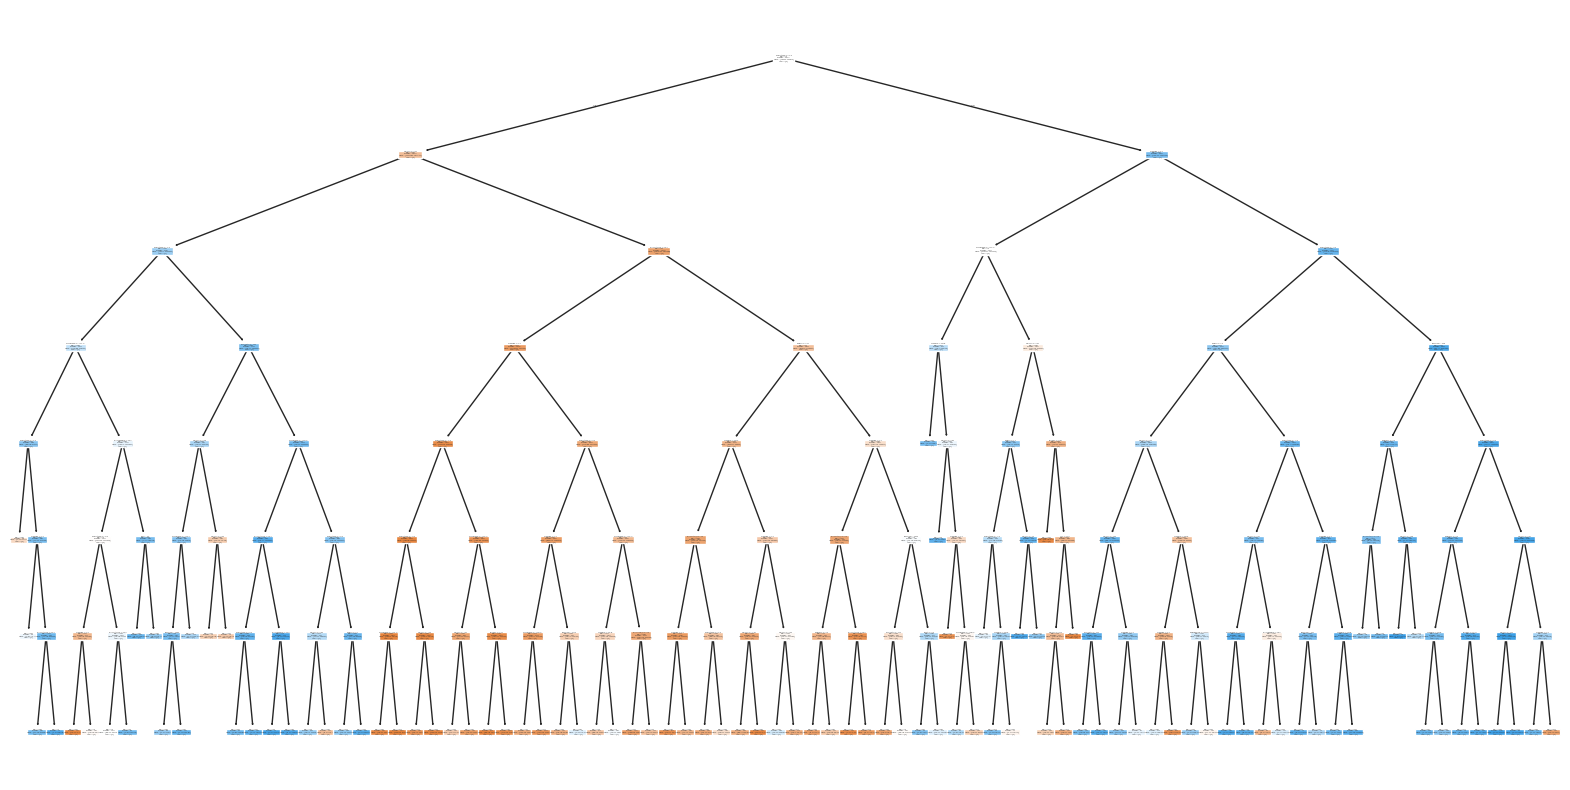

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(modelo_rf.estimators_[0], filled=True, feature_names=ds_m2.columns, class_names=True)
plt.show()

Primer árbol reducido

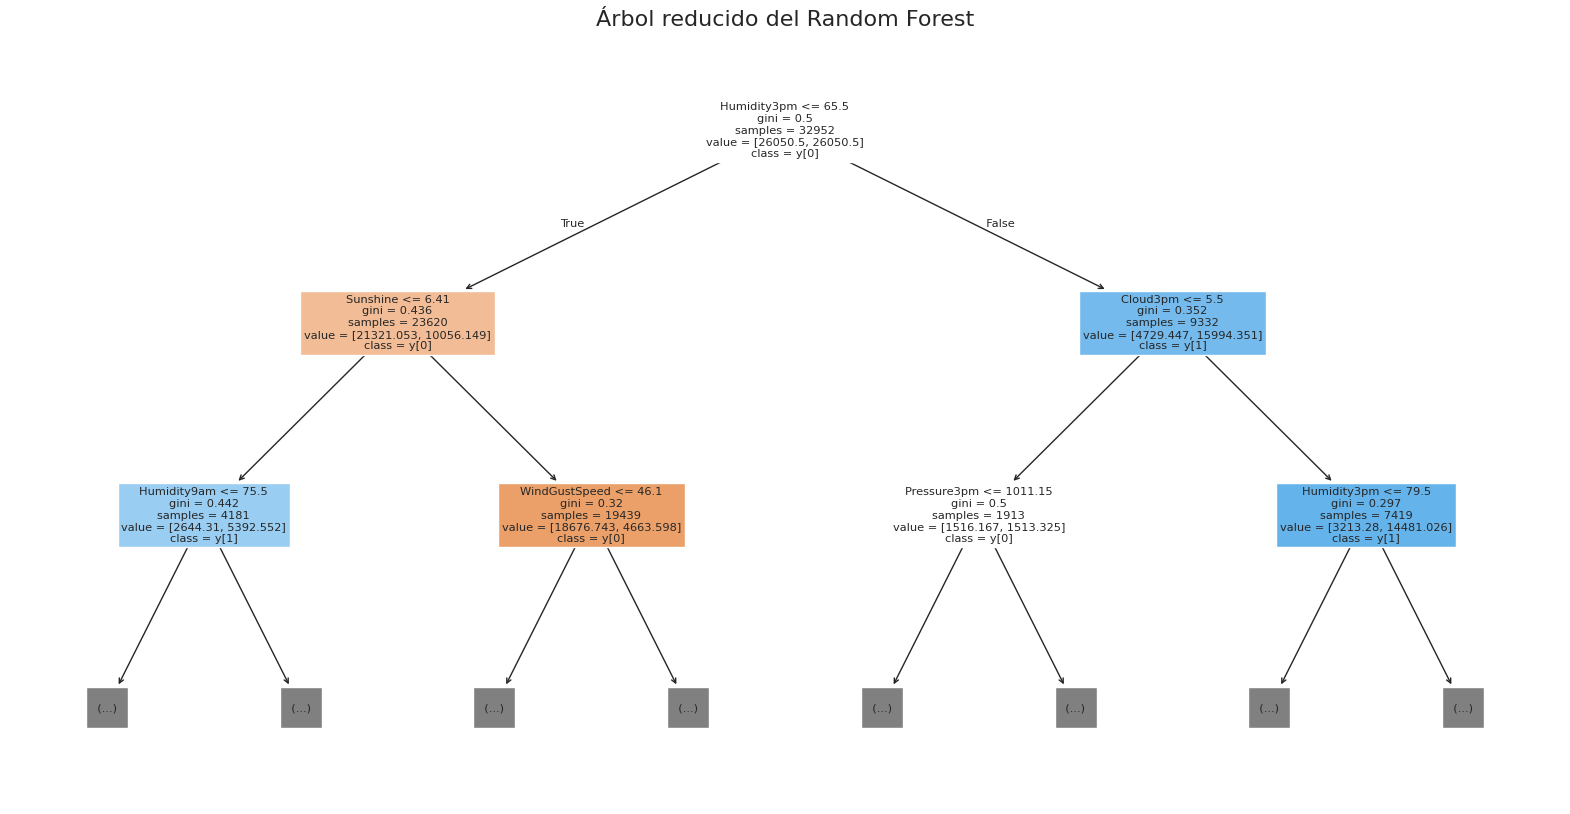

In [ ]:
plt.figure(figsize=(20, 10))
plot_tree(
    modelo_rf.estimators_[0],
    filled=True,
    feature_names=ds_m2.columns,
    class_names=True,
    max_depth=2
)
plt.title("Árbol reducido del Random Forest", fontsize=16)
plt.show()

Bosque completo

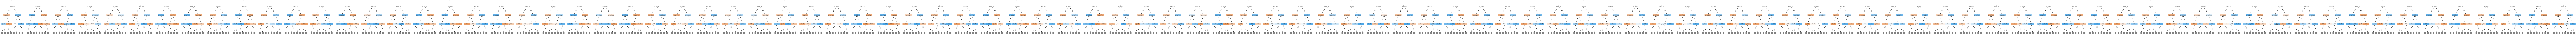

In [ ]:
n_arboles = len(modelo_rf.estimators_)
fig, axes = plt.subplots(nrows=1, ncols=n_arboles, figsize=(n_arboles * 4, 6))

for i, arbol in enumerate(modelo_rf.estimators_):
    plot_tree(
        arbol,
        ax=axes[i],
        filled=True,
        max_depth=2,  # Podés ajustar esto si querés más profundidad
        feature_names=ds_m2.columns,
        class_names=[str(c) for c in modelo_rf.classes_],
        fontsize=4
    )
    axes[i].set_title(f"Árbol {i}", fontsize=6)

plt.tight_layout()
plt.show()

#####Evaluación del modelo en TRAIN y TEST

In [ ]:
# TEST
y_m2_test_pred = modelo_rf.predict(x_m2_test)

# TRAIN
y_m2_train_pred = modelo_rf.predict(x_m2_train)

##### Métricas obtenidas

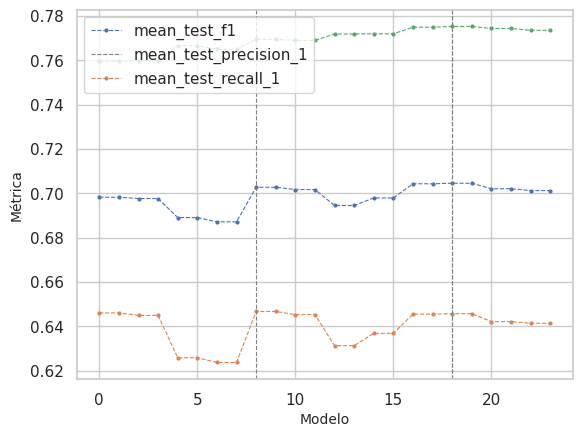

In [ ]:
labels=[ key for key in gs_multimetrica_fit.cv_results_.keys() if("mean_test" in key)]

for k in labels:
    plt.plot(gs_multimetrica_fit.cv_results_[k],linestyle='--' , linewidth=0.8,marker='o',markersize=2)
    x_linea=np.argmax(gs_multimetrica_fit.cv_results_[k])
    plt.axvline(x_linea,linestyle='--' ,linewidth=0.8,color='grey')

plt.xlabel("Modelo", fontsize=10)
plt.ylabel("Métrica", fontsize=10)
plt.legend(labels)
plt.show()

Matrices de confusión

              precision    recall  f1-score   support

         0.0       0.93      0.87      0.90     10020
         1.0       0.64      0.78      0.70      2996

    accuracy                           0.85     13016
   macro avg       0.79      0.82      0.80     13016
weighted avg       0.86      0.85      0.85     13016



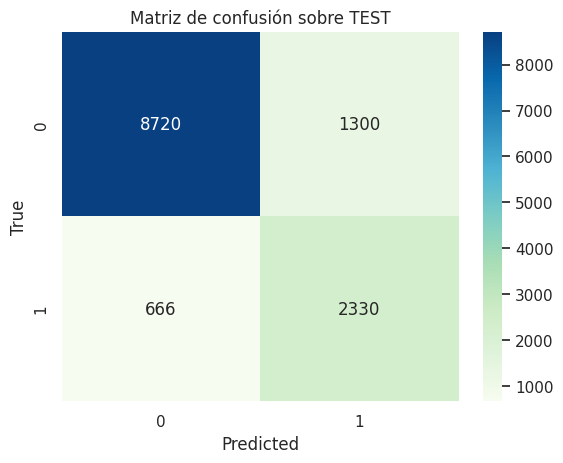

In [ ]:
# Creo la matriz de confusión
tabla = confusion_matrix(y_m2_test, y_m2_test_pred)

# La grafico
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Matriz de confusión sobre TEST")

# Reporte
print(classification_report(y_m2_test, y_m2_test_pred))

              precision    recall  f1-score   support

         0.0       0.93      0.87      0.90     10020
         1.0       0.64      0.78      0.70      2996

    accuracy                           0.85     13016
   macro avg       0.79      0.82      0.80     13016
weighted avg       0.86      0.85      0.85     13016



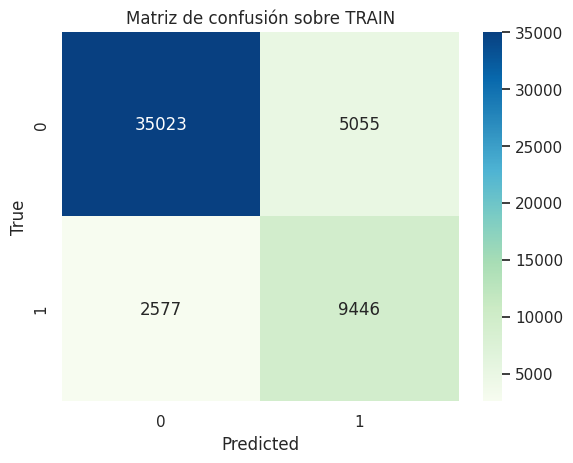

In [ ]:
# Creo la matriz de confusión
tabla = confusion_matrix(y_m2_train, y_m2_train_pred)

# La grafico
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Matriz de confusión sobre TRAIN")

# Reporte
print(classification_report(y_m2_test, y_m2_test_pred))

Curva ROC

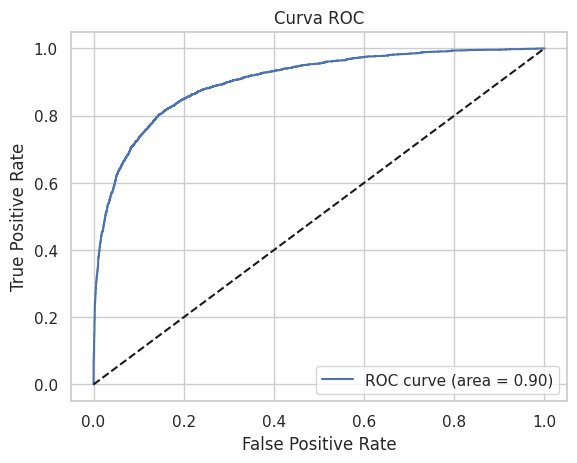

In [ ]:
from sklearn.metrics import roc_curve, auc

y_proba = modelo_rf.predict_proba(x_m2_test)[:, 1]
fpr, tpr, _ = roc_curve(y_m2_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

Reportes

In [ ]:
from sklearn.metrics import classification_report

print("🔹 Métricas en TRAIN:")
print(classification_report(y_m2_train, y_m2_train_pred, digits=3))

print("🔹 Métricas en TEST:")
print(classification_report(y_m2_test, y_m2_test_pred, digits=3))

🔹 Métricas en TRAIN:
              precision    recall  f1-score   support

         0.0      0.931     0.874     0.902     40078
         1.0      0.651     0.786     0.712     12023

    accuracy                          0.854     52101
   macro avg      0.791     0.830     0.807     52101
weighted avg      0.867     0.854     0.858     52101

🔹 Métricas en TEST:
              precision    recall  f1-score   support

         0.0      0.929     0.870     0.899     10020
         1.0      0.642     0.778     0.703      2996

    accuracy                          0.849     13016
   macro avg      0.785     0.824     0.801     13016
weighted avg      0.863     0.849     0.854     13016



##### Guardo el modelo

In [ ]:
with open("random_forest.pkl", "wb") as f:
    pickle.dump(modelo_rf, f)

### Modelo 3: XGBoost


In [ ]:
ds_m3 = ds.copy()

##### Set entrenamiento y test

In [ ]:
ds_m3_x = ds_m3.drop(['RainTomorrow'], axis='columns', inplace=False)

ds_m3_y = ds_m3['RainTomorrow'].copy()

SEED = 42
x_m3_train, x_m3_test, y_m3_train, y_m3_test = train_test_split(ds_m3_x,
                                                    ds_m3_y,
                                                    test_size=0.2,  #proporcion 80/20
                                                    random_state=SEED, #semilla
                                                    stratify=ds_m3_y.values) #proporcion de clases en los sets

In [ ]:
# Verifico Cantidad de Datos en cada set
print('# Datos Entrenamiento: {}'.format(len(x_m3_train)))
print('# Datos Prueba: {}'.format(len(x_m3_test)))

# Datos Entrenamiento: 52063
# Datos Prueba: 13016


Mostramos algunos registros de cada set

In [ ]:
x_m3_train.head(2)

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
45361     13.0     24.7      11.4          4.3      9.44           37.0   
41107     -0.6     14.0       0.0          1.2      7.10           41.0   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  \
45361          15.0          13.0         72.0         43.0  ...   
41107           2.0          22.0         86.0         59.0  ...   

       City_Territorio de la capital  WindGustDir_N  WindGustDir_S  \
45361                              1              0              0   
41107                              1              0              0   

       WindGustDir_W  WindDir9am_N  WindDir9am_S  WindDir9am_W  WindDir3pm_N  \
45361              0             0             1             0             0   
41107              1             0             0             1             0   

       WindDir3pm_S  WindDir3pm_W  
45361             1             0  
41107             0             1  

[2 rows x 31 columns]

In [ ]:
y_m3_train.head(2)

45361    0.0
41107    0.0
Name: RainTomorrow, dtype: float64

In [ ]:
x_m3_test.head(2)

MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
10253     24.6     35.0       0.0         7.20      8.50           52.0   
902        4.3      9.2       4.2         1.32      3.76           28.0   

       WindSpeed9am  WindSpeed3pm  Humidity9am  Humidity3pm  ...  \
10253          17.0          39.0         55.0         63.0  ...   
902            13.0          19.0         94.0         87.0  ...   

       City_Territorio de la capital  WindGustDir_N  WindGustDir_S  \
10253                              0              1              0   
902                                0              0              0   

       WindGustDir_W  WindDir9am_N  WindDir9am_S  WindDir9am_W  WindDir3pm_N  \
10253              0             0             0             1             1   
902                1             0             0             1             0   

       WindDir3pm_S  WindDir3pm_W  
10253             0             0  
902               0             1  

[2 rows x 31 columns]

In [ ]:
y_m3_test.head(2)

10253    0.0
902      0.0
Name: RainTomorrow, dtype: float64

##### Búsqueda de hiperparámetros

In [ ]:
xgb_classifier = xgb.XGBClassifier()

param_grid = {
    'n_estimators': [100, 200],  # Alto para compensar learning_rate bajo
    'max_depth': [3, 4],         # Bajo para evitar overfitting
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [1, 5, 10],
}

scoring = {
    'f1': 'f1',
    'precision_1': make_scorer(precision_score, pos_label=1),
    'recall_1': make_scorer(recall_score, pos_label=1)
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

gs_xgb = GridSearchCV(estimator=xgb_classifier,
                      param_grid=param_grid,
                      cv=skf,
                      scoring=scoring,
                      refit="f1"
                      )

Entrenamiento:

In [ ]:
gs_xgb.fit(x_m3_train, y_m3_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, feature_weights=None,
                                     gamma=None, grow_polic...
             param_grid={'colsample_bytree': [0.8, 0.9],
                         'learning_rate': [0.05, 0.1], 'max_depth': [3, 4],
                         'n_estimators': [100, 200], 'reg_alpha': [0, 0.1, 0.5],
                         'reg_lambda': [1, 5, 10], 'subsample': [0.8, 0.9]},
             refit='f1',
             scoring={'f1': 'f1',
                      'precision_1': make_scorer(precision_score, response_method='predict', pos_label=1),
                      'recall_1': make_scorer(recall_score, response_method='predict', pos_label=1)})

In [ ]:
modelo_xgb = gs_xgb.best_estimator_

Mejores hiperparámetros del modelo:

In [ ]:
print(gs_xgb.best_params_)

{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'reg_alpha': 0.1, 'reg_lambda': 5, 'subsample': 0.8}


Importancia de los parámetros

In [ ]:
sorted(list(zip(ds_m3.columns.to_list(), modelo_xgb.feature_importances_)), key = lambda x: -x[1])

[('Sunshine', np.float32(0.29725522)),
 ('RainToday', np.float32(0.09922026)),
 ('Humidity3pm', np.float32(0.08275346)),
 ('Cloud3pm', np.float32(0.053822476)),
 ('Rainfall', np.float32(0.040766116)),
 ('Cloud9am', np.float32(0.039835613)),
 ('WindGustSpeed', np.float32(0.030754533)),
 ('Pressure3pm', np.float32(0.02798192)),
 ('Humidity9am', np.float32(0.023075199)),
 ('Day', np.float32(0.02239372)),
 ('WindDir3pm_N', np.float32(0.019053366)),
 ('WindGustDir_N', np.float32(0.018947393)),
 ('MinTemp', np.float32(0.018803949)),
 ('City_Territorio de la capital', np.float32(0.017233815)),
 ('WindGustDir_S', np.float32(0.016764447)),
 ('RainTomorrow', np.float32(0.016346969)),
 ('Pressure9am', np.float32(0.014860417)),
 ('City_Queensland', np.float32(0.014645973)),
 ('Temp3pm', np.float32(0.014471798)),
 ('MaxTemp', np.float32(0.014299845)),
 ('Evaporation', np.float32(0.013227516)),
 ('Temp9am', np.float32(0.013000838)),
 ('WindSpeed9am', np.float32(0.012684287)),
 ('Year', np.float32(0.

##### Evaluación del modelo en TRAIN y TEST

In [ ]:
# TEST
y_m3_test_pred = modelo_xgb.predict(x_m3_test)

# TRAIN
y_m3_train_pred = modelo_xgb.predict(x_m3_train)

##### Métricas obtenidas

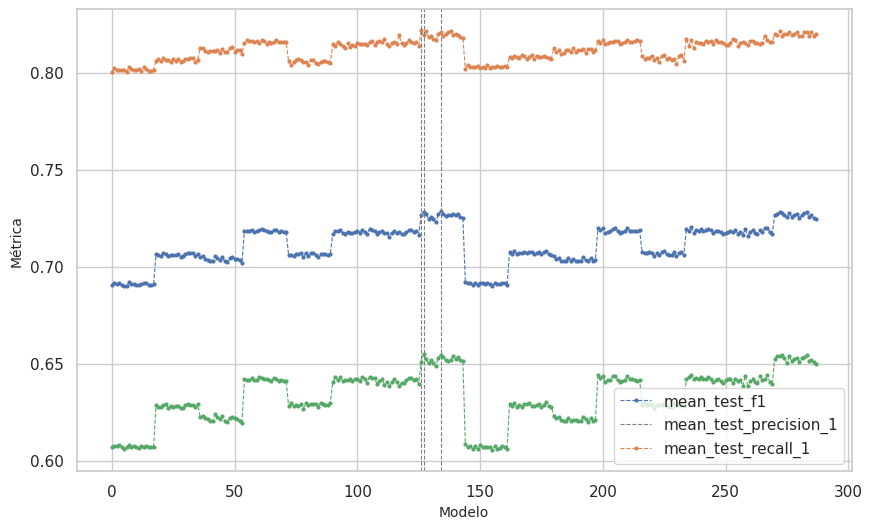

In [ ]:
labels = [key for key in gs_xgb.cv_results_.keys() if "mean_test" in key]

plt.figure(figsize=(10, 6))

for k in labels:
    valores = gs_xgb.cv_results_[k]

    # Graficar la curva de la métrica
    plt.plot(valores, linestyle='--', linewidth=0.8, marker='o', markersize=2, label=k)

    # Marcar el mejor punto
    x_linea = np.argmax(valores)
    plt.axvline(x_linea, linestyle='--', linewidth=0.8, color='grey')

# Etiquetas y leyenda
plt.xlabel("Modelo", fontsize=10)
plt.ylabel("Métrica", fontsize=10)
plt.legend(labels)
plt.show()

Matrices de confusión

Text(0.5, 1.0, 'Matriz de confusión sobre TEST')

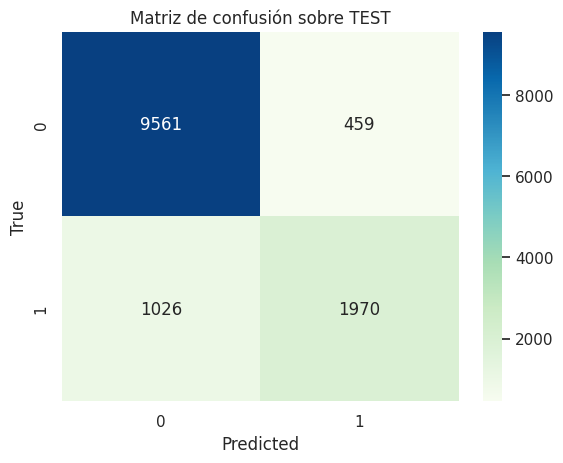

In [ ]:
tabla = confusion_matrix(y_m3_test, y_m3_test_pred)

sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Matriz de confusión sobre TEST")

Text(0.5, 1.0, 'Matriz de confusión sobre TRAIN')

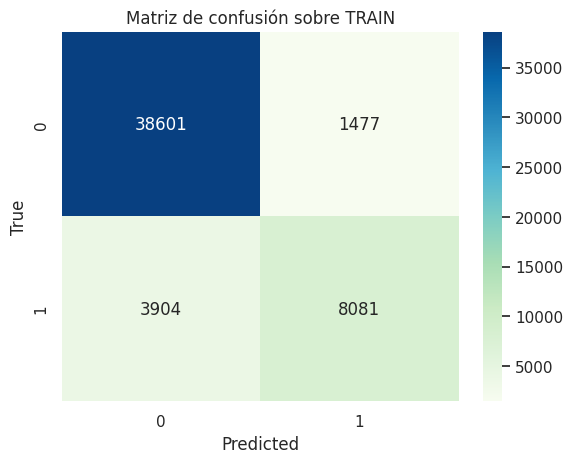

In [ ]:
tabla = confusion_matrix(y_m3_train, y_m3_train_pred)

# La grafico
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title("Matriz de confusión sobre TRAIN")

Curva ROC

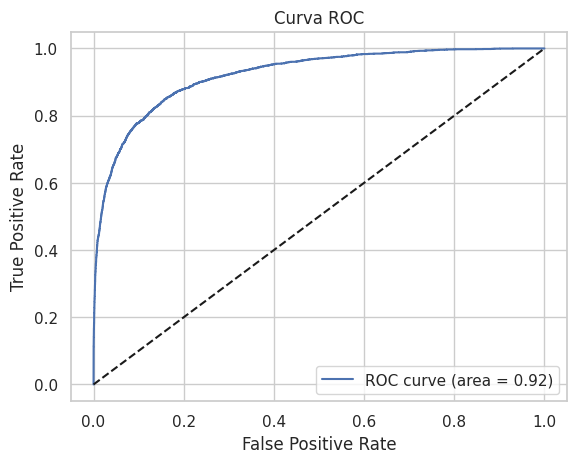

In [ ]:
y_proba = modelo_xgb.predict_proba(x_m3_test)[:, 1]
fpr, tpr, _ = roc_curve(y_m3_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

Reportes

In [ ]:
# Obtener predicciones en el conjunto de prueba
y_m3_test_pred = modelo_xgb.predict(x_m3_test)

y_m3_train_pred = modelo_xgb.predict(x_m3_train)

print("🔹 Métricas en TRAIN:")
print(classification_report(y_m3_train, y_m3_train_pred, digits=3))

print("🔹 Métricas en TEST:")
print(classification_report(y_m3_test, y_m3_test_pred, digits=3))

🔹 Métricas en TRAIN:
              precision    recall  f1-score   support

         0.0      0.908     0.963     0.935     40078
         1.0      0.845     0.674     0.750     11985

    accuracy                          0.897     52063
   macro avg      0.877     0.819     0.843     52063
weighted avg      0.894     0.897     0.892     52063

🔹 Métricas en TEST:
              precision    recall  f1-score   support

         0.0      0.903     0.954     0.928     10020
         1.0      0.811     0.658     0.726      2996

    accuracy                          0.886     13016
   macro avg      0.857     0.806     0.827     13016
weighted avg      0.882     0.886     0.882     13016



##### Guardo el modelo

In [ ]:
with open("XGBoost.pkl", "wb") as f:
    pickle.dump(modelo_xgb, f)